In [1]:
import pandas as pd
import shutil
import os
import numpy as np
import matplotlib.pyplot as plt
import onekey_algo.custom.components as okcomp
from onekey_algo import get_param_in_cwd

plt.rcParams['figure.dpi'] = 300
model_names = ['Clinical', 'Pathology', 'Combined']
# model_names = ['Clinical', 'DeepLearning']
# 获取配置
task = get_param_in_cwd('task_column') or 'label'
bst_model = 'LR'
labelf = get_param_in_cwd('label_file') or os.path.join(mydir, 'label.csv')
group_info = get_param_in_cwd('dataset_column') or 'group'

# 读取label文件。
labels = [task]
label_data_ = pd.read_csv(labelf).drop_duplicates('ID')
label_data_ = label_data_[['ID', group_info, task]]
label_data_ = label_data_.dropna(axis=0)

ids = label_data_['ID']
print(label_data_.columns)
label_data = label_data_[['ID'] + labels]
label_data

Index(['ID', 'group', 'label'], dtype='object')


,ID,label
0,229,0
1,114,0
2,98,0
3,17,0
4,30,0
...,...,...
219,82,0
220,217,0
221,51,0
222,121,0


# 训练集-Nomogram

In [2]:
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df

subset = 'train'
Clinic_results = pd.merge(pd.read_csv(f'./results/Clinical_LightGBM_{subset}.csv', header=0), label_data, on='ID', how='inner')
DTL_results = pd.merge(pd.read_csv(f'./results/Path_LR_{subset}.csv', header=0), label_data, on='ID', how='inner')

ALL_results = pd.merge(Clinic_results, DTL_results, on='ID', how='inner')
ALL_results.columns = ['ID', '-0', model_names[0], task, '-00', model_names[1], '-l']
Clinic = pd.read_csv('clinic_sel.csv')
Clinic_features = [c for c in Clinic.columns if c not in ['ID', task, group_info]]
Clinic = Clinic[['ID'] + Clinic_features]
# ALL_results = normalize_df(ALL_results, not_norm=['ID'], method='minmax')
ALL_results = pd.merge(ALL_results, Clinic, on='ID', how='inner')
ALL_results = ALL_results.dropna(axis=1)
ALL_results

,ID,-0,Clinical,label,-00,Pathology,-l,Tg
0,0,0.904,0.096,0,9.825e-01,0.017,0,33.02
1,1,0.821,0.179,0,9.888e-01,0.011,0,4.60
2,2,0.764,0.236,0,9.870e-01,0.013,0,58.33
3,5,0.386,0.614,1,5.642e-03,0.994,1,8.98
4,7,0.554,0.446,0,9.850e-01,0.015,0,5.65
...,...,...,...,...,...,...,...,...
151,229,0.839,0.161,0,9.843e-01,0.016,0,0.29
152,230,0.443,0.557,0,9.856e-01,0.014,0,4.85
153,231,0.150,0.850,1,8.043e-04,0.999,1,75.47
154,235,0.516,0.484,1,1.409e-03,0.999,1,1.79


In [3]:
from sklearn.linear_model import LogisticRegression
import joblib
from sklearn.svm import SVC
from onekey_algo.custom.components import metrics

mnames = ['SVM', 'KNN', 'ExtraTrees', 'XGBoost', 'MLP', 'LR', 'nb', 'AdaBoost']
models = okcomp.comp1.create_clf_model(mnames)
# mnames = list(models.keys())

model = LogisticRegression(penalty='l2', max_iter=100)
# model = SVC(probability=True, random_state=0)
data_x = ALL_results[Clinic_features + [model_names[1]]]
# data_x = ALL_results[model_names[:2]]
data_y = ALL_results[task]
model.fit(data_x, data_y)
joblib.dump(model, f'models/Nomogram_LR_{subset}.pkl') 
results = model.predict_proba(data_x)
results = pd.DataFrame(results, index=ALL_results['ID'], columns=[f'{task}-0', f'{task}-1']).reset_index()
results.to_csv(f'./results/Nomo_{subset}.csv', index=False, header=True)
pd.DataFrame([metrics.analysis_pred_binary(ALL_results[task], results[f'{task}-1'])], 
                  columns=['acc', 'auc', '95%CI', 'Sensitivity', 'Specificity', 'PPV', 'NPV', 'Precision', 'Recall', 'F1', 'Threshold'])

,acc,auc,95%CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold
0,0.981,0.973,"[0.920064, 1.0]",0.941,0.992,0.97,0.984,0.97,0.941,0.955,0.303


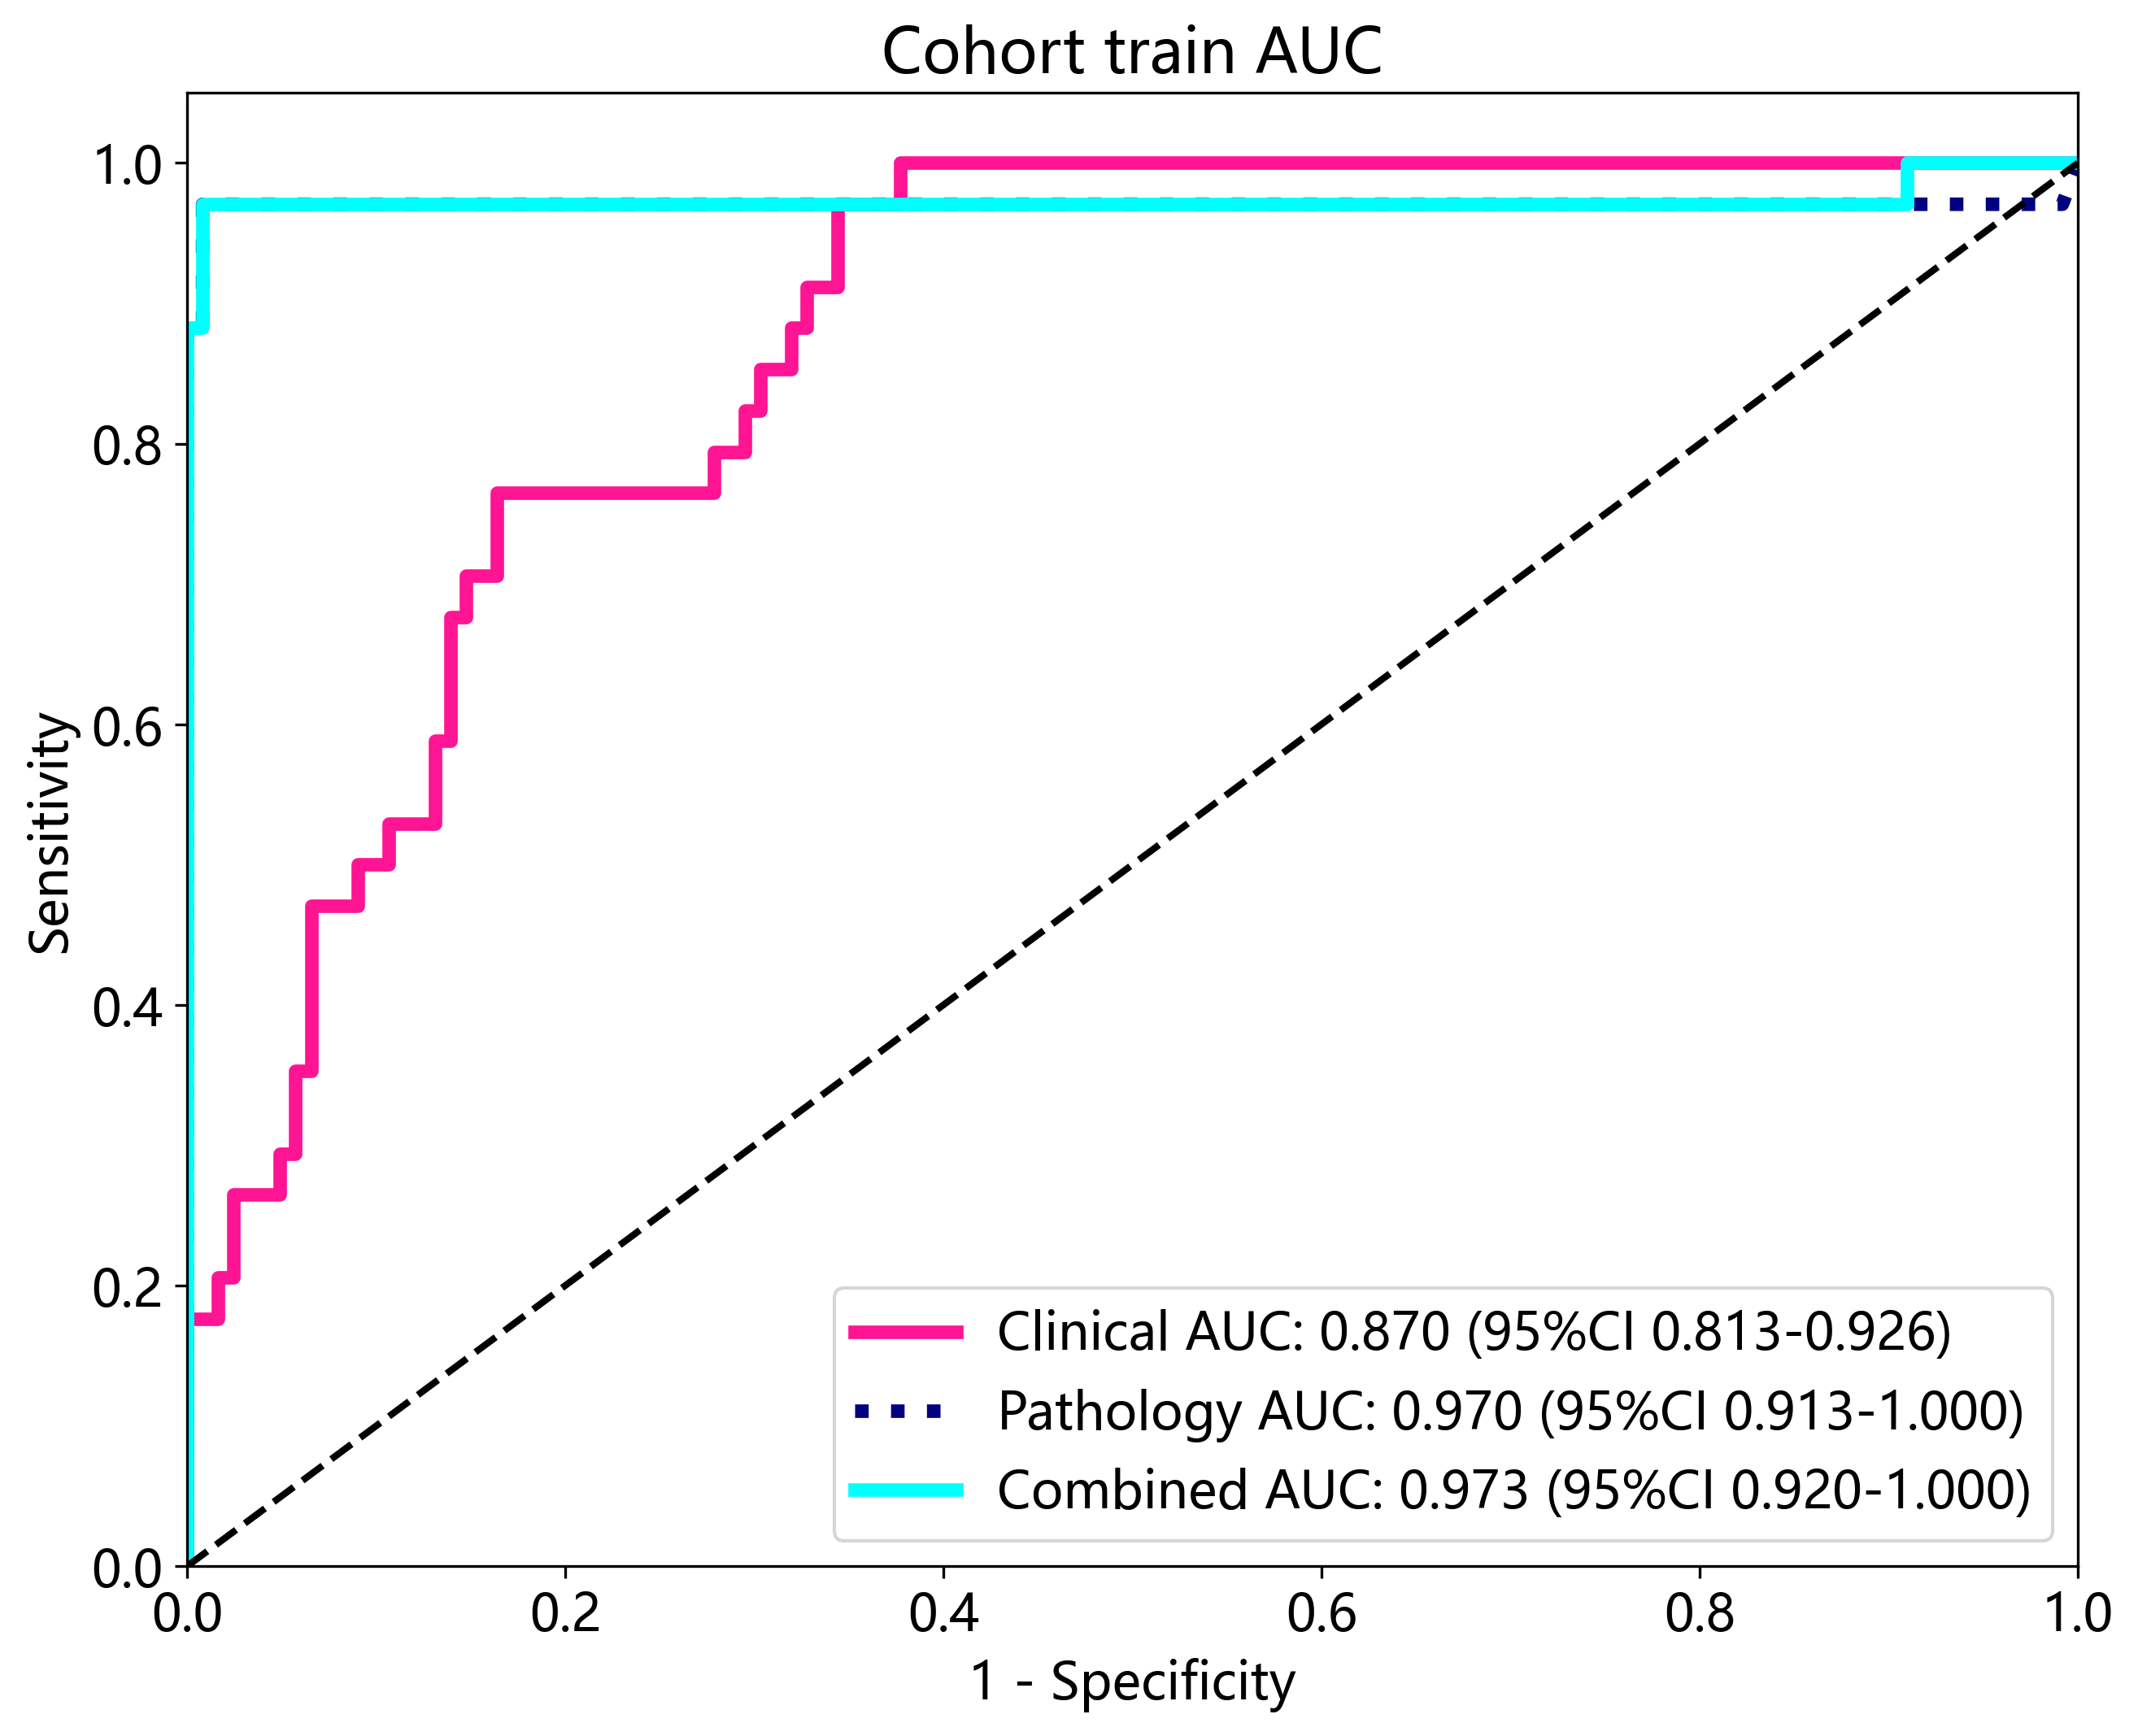

In [4]:
results.columns = ['ID', '-', model_names[-1]]
ALL_results = pd.merge(ALL_results, results, on='ID', how='inner')
# Nomo_results.columns = ['ID', model_names[-1]]
# ALL_results = pd.merge(ALL_results, Nomo_results, on='ID', how='inner')
# model_names += list(Human_results.columns[1:])
gt = [np.array(ALL_results[task]) for d in model_names]
pred_train = [np.array(ALL_results[d]) for d in model_names]
okcomp.comp1.draw_roc(gt, pred_train, labels=model_names, title=f"Cohort {subset} AUC", auto_point=True, 
                      markers=[ '.', ',', 'o', '.', ',', 'o', ], point_colors=['red', 'red', 'red', 'green', 'green', 'green'])
plt.savefig(f'img/{subset}_auc.svg')

In [5]:
from onekey_algo.custom.components.metrics import analysis_pred_binary
metric = []
youden = {}
for mname, y, score in zip(model_names, gt, pred_train):
    # 计算验证集指标
    acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y, score, use_youden=False)
    ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
    metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, f"Train"))
    youden[mname] = 0.5
pd.DataFrame(metric, index=None, columns=['Signature', 'Accuracy', 'AUC', '95% CI', 'Sensitivity', 'Specificity', 
                                          'PPV', 'NPV', 'Precision', 'Recall', 'F1','Threshold', 'Cohort'])

,Signature,Accuracy,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold,Cohort
0,Clinical,0.808,0.870,0.8132 - 0.9260,0.618,0.861,0.553,0.890,0.553,0.618,0.583,0.348,Train
1,Pathology,0.981,0.970,0.9126 - 1.0000,0.941,0.992,0.970,0.984,0.970,0.941,0.955,0.477,Train
2,Combined,0.981,0.973,0.9201 - 1.0000,0.941,0.992,0.970,0.984,0.970,0.941,0.955,0.303,Train


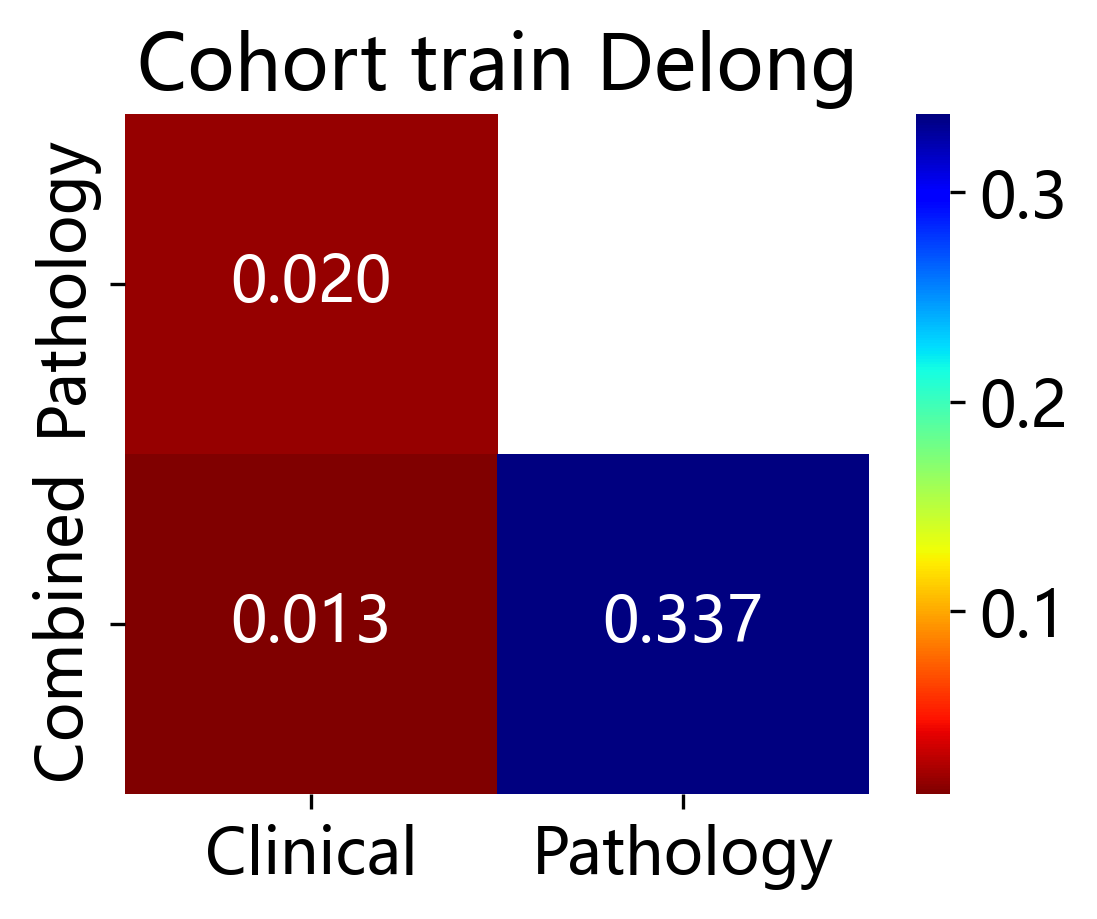

In [6]:
from onekey_algo.custom.components.delong import delong_roc_test
from onekey_algo.custom.components.comp1 import draw_matrix

delong = []
delong_columns = []
this_delong = []
plt.figure(figsize=(4, 3))
cm = np.zeros((len(model_names), len(model_names)))
for i, mni in enumerate(model_names):
    for j, mnj in enumerate(model_names):
        if i <= j:
            cm[i][j] = np.nan
        else:
            cm[i][j] = delong_roc_test(ALL_results[task], ALL_results[mni], ALL_results[mnj])[0][0]
cm = pd.DataFrame(cm[1:, :-1], index=model_names[1:], columns=model_names[:-1])
draw_matrix(cm, annot=True, cmap='jet_r', cbar=True)
plt.title(f'Cohort {subset} Delong')
plt.savefig(f'img/delong_each_cohort_{subset}.svg', bbox_inches = 'tight')
plt.show()

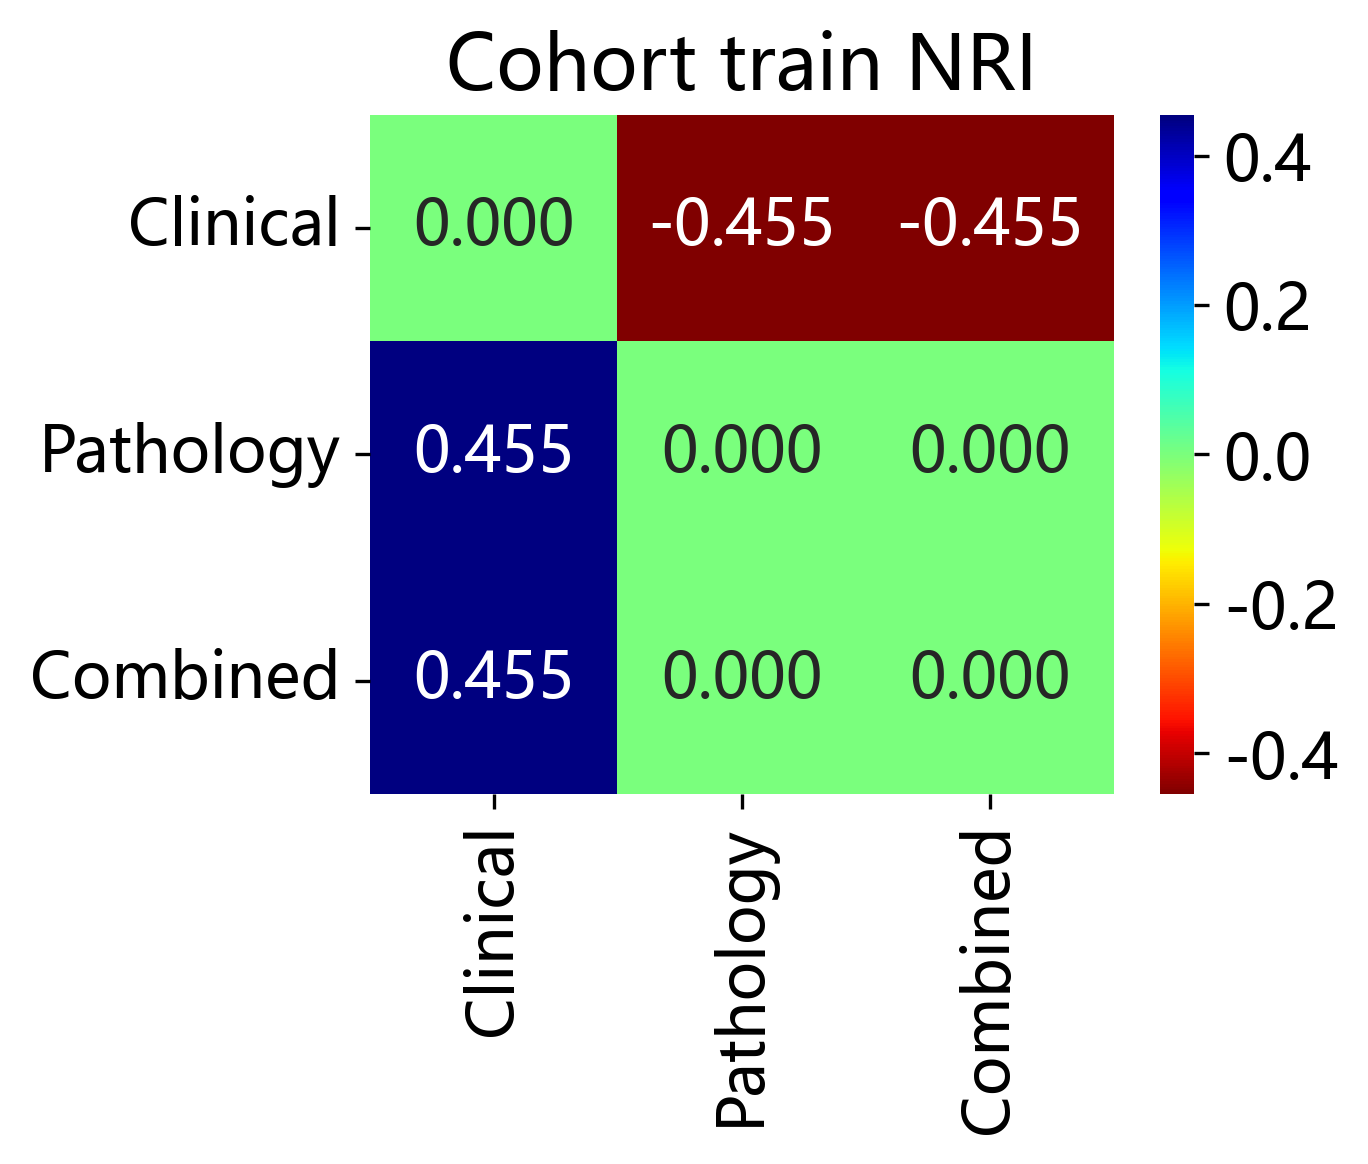

In [7]:
from onekey_algo.custom.components.delong import delong_roc_test
from onekey_algo.custom.components.metrics import NRI, IDI

delong = []
delong_columns = []
this_delong = []
plt.figure(figsize=(4, 3))
cm = np.zeros((len(model_names), len(model_names)))
for i, mni in enumerate(model_names):
    for j, mnj in enumerate(model_names):
        cm[i][j] = NRI(ALL_results[mni] > youden[mni], ALL_results[mnj] > youden[mnj], ALL_results[task])
cm = pd.DataFrame(cm, index=model_names, columns=model_names)
draw_matrix(cm, annot=True, cmap='jet_r', cbar=True)
plt.title(f'Cohort {subset} NRI')
plt.savefig(f'img/NRI_each_cohort_{subset}.svg', bbox_inches = 'tight')
plt.show()

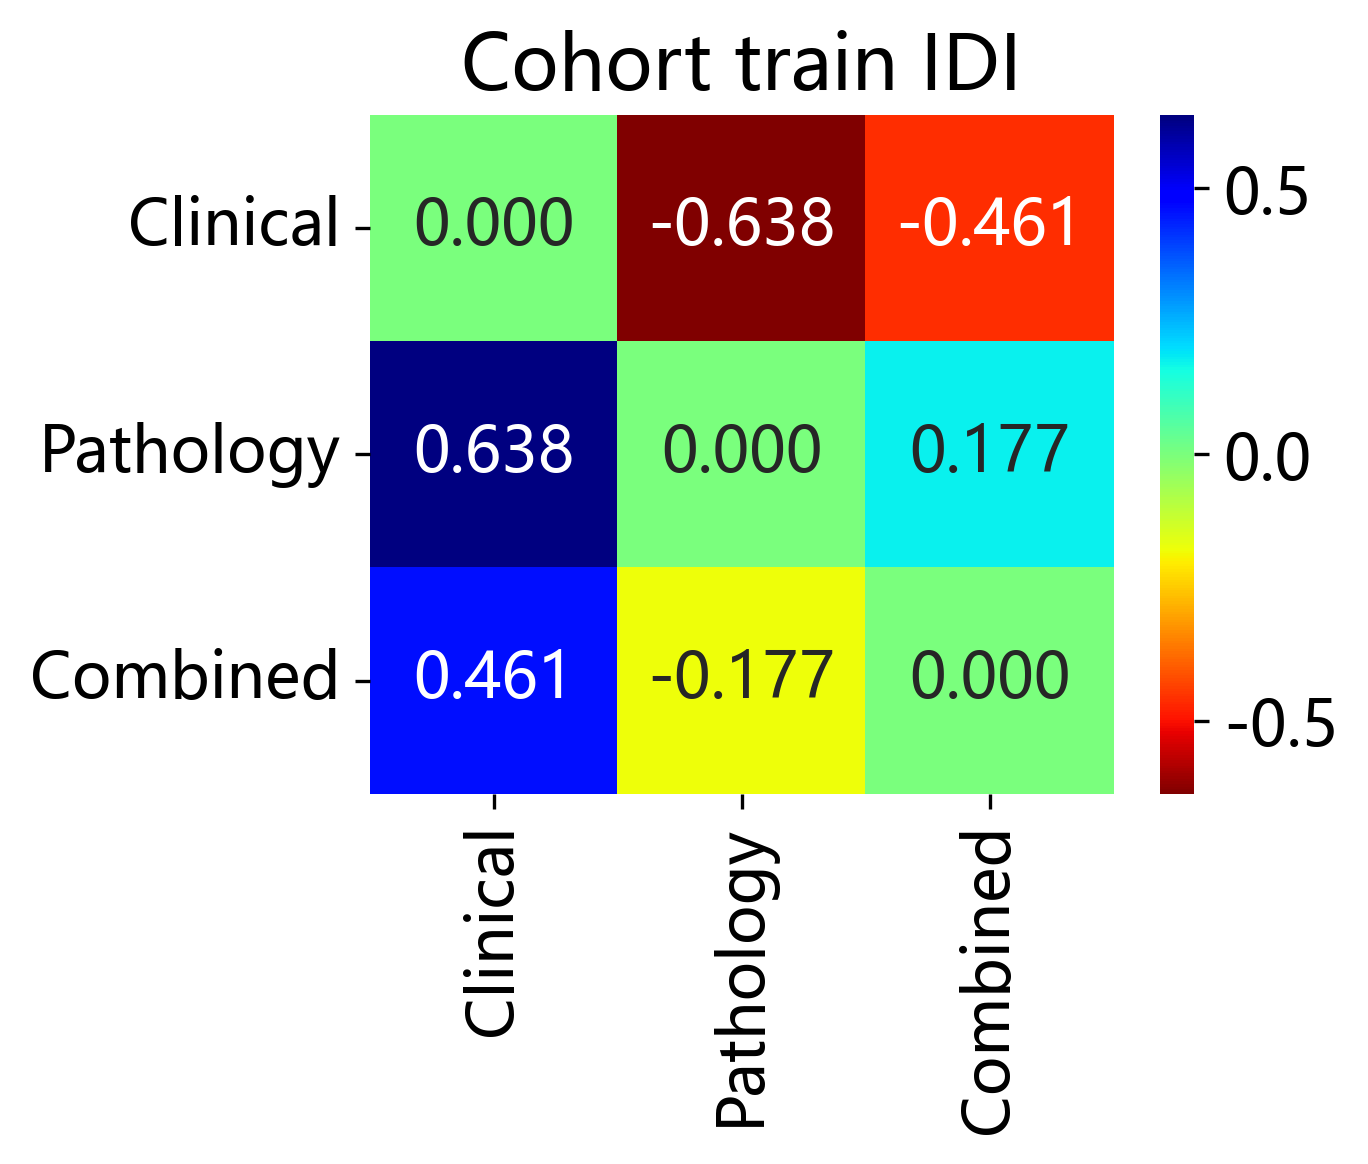

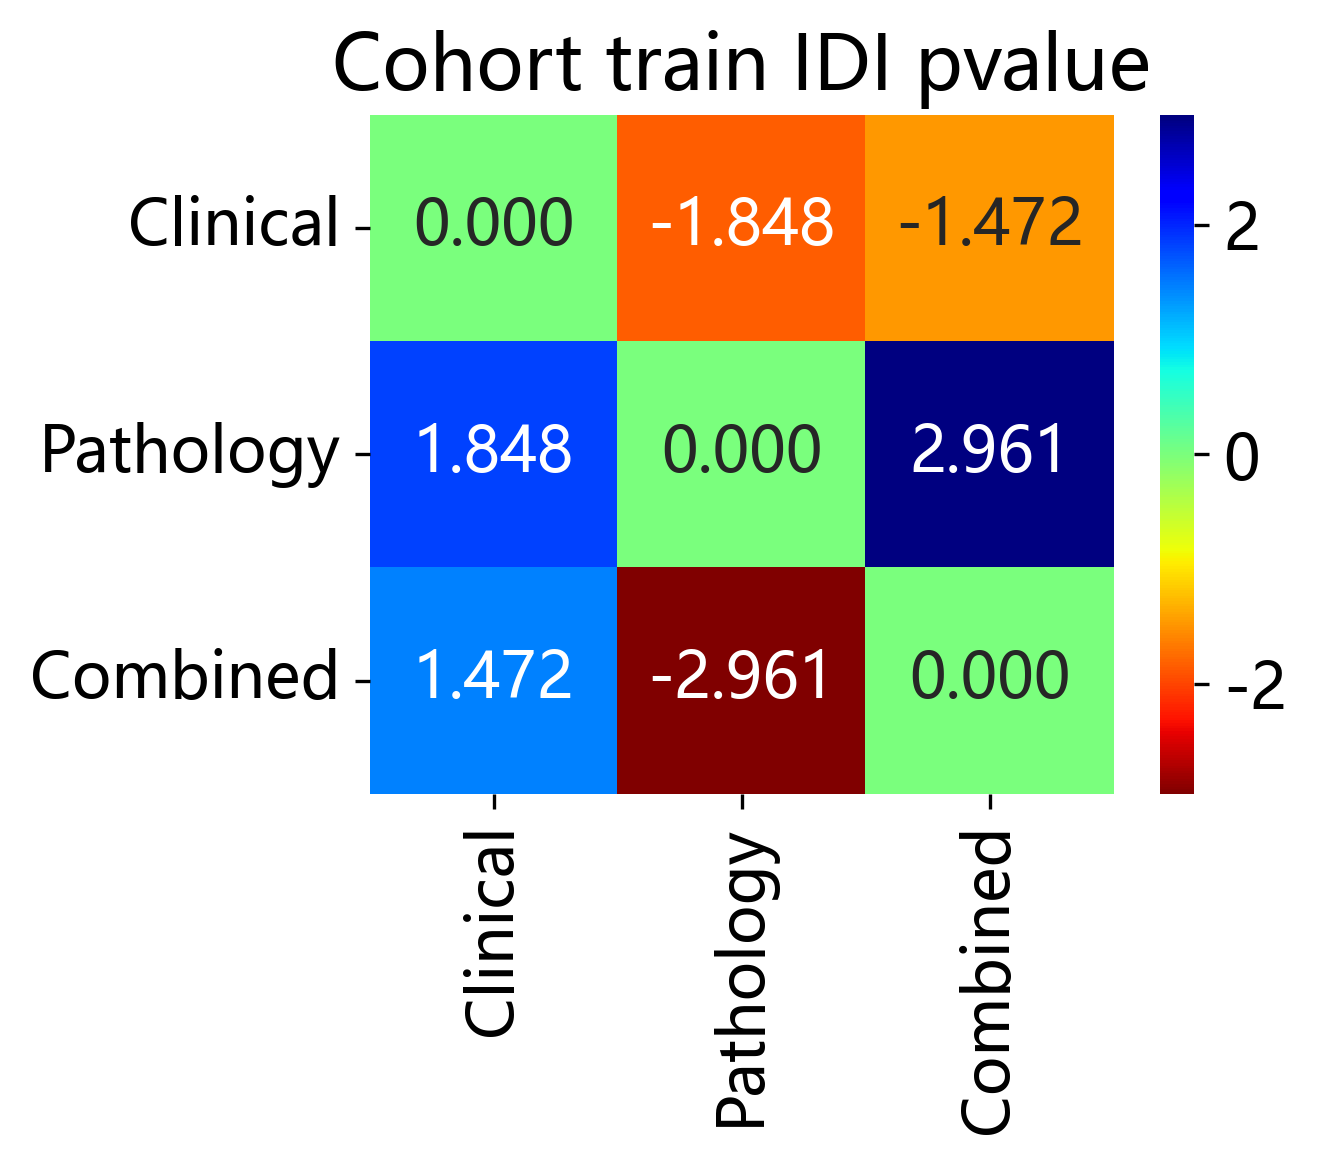

In [8]:
from onekey_algo.custom.components.delong import delong_roc_test
from onekey_algo.custom.components.metrics import NRI, IDI

delong = []
delong_columns = []
this_delong = []
cm = np.zeros((len(model_names), len(model_names)))
p = np.zeros((len(model_names), len(model_names)))
for i, mni in enumerate(model_names):
    for j, mnj in enumerate(model_names):
        cm[i][j], p[i][j] = IDI(ALL_results[mni], ALL_results[mnj], ALL_results[task], with_p=True)

for d, n in zip([cm, p], ['IDI', 'IDI pvalue']):
    plt.figure(figsize=(4, 3))
    d = pd.DataFrame(d, index=model_names, columns=model_names)
    draw_matrix(d, annot=True, cmap='jet_r', cbar=True)
    plt.title(f'Cohort {subset} {n}')
    plt.savefig(f'img/{n}_each_cohort_{subset}.svg', bbox_inches = 'tight')
    plt.show()

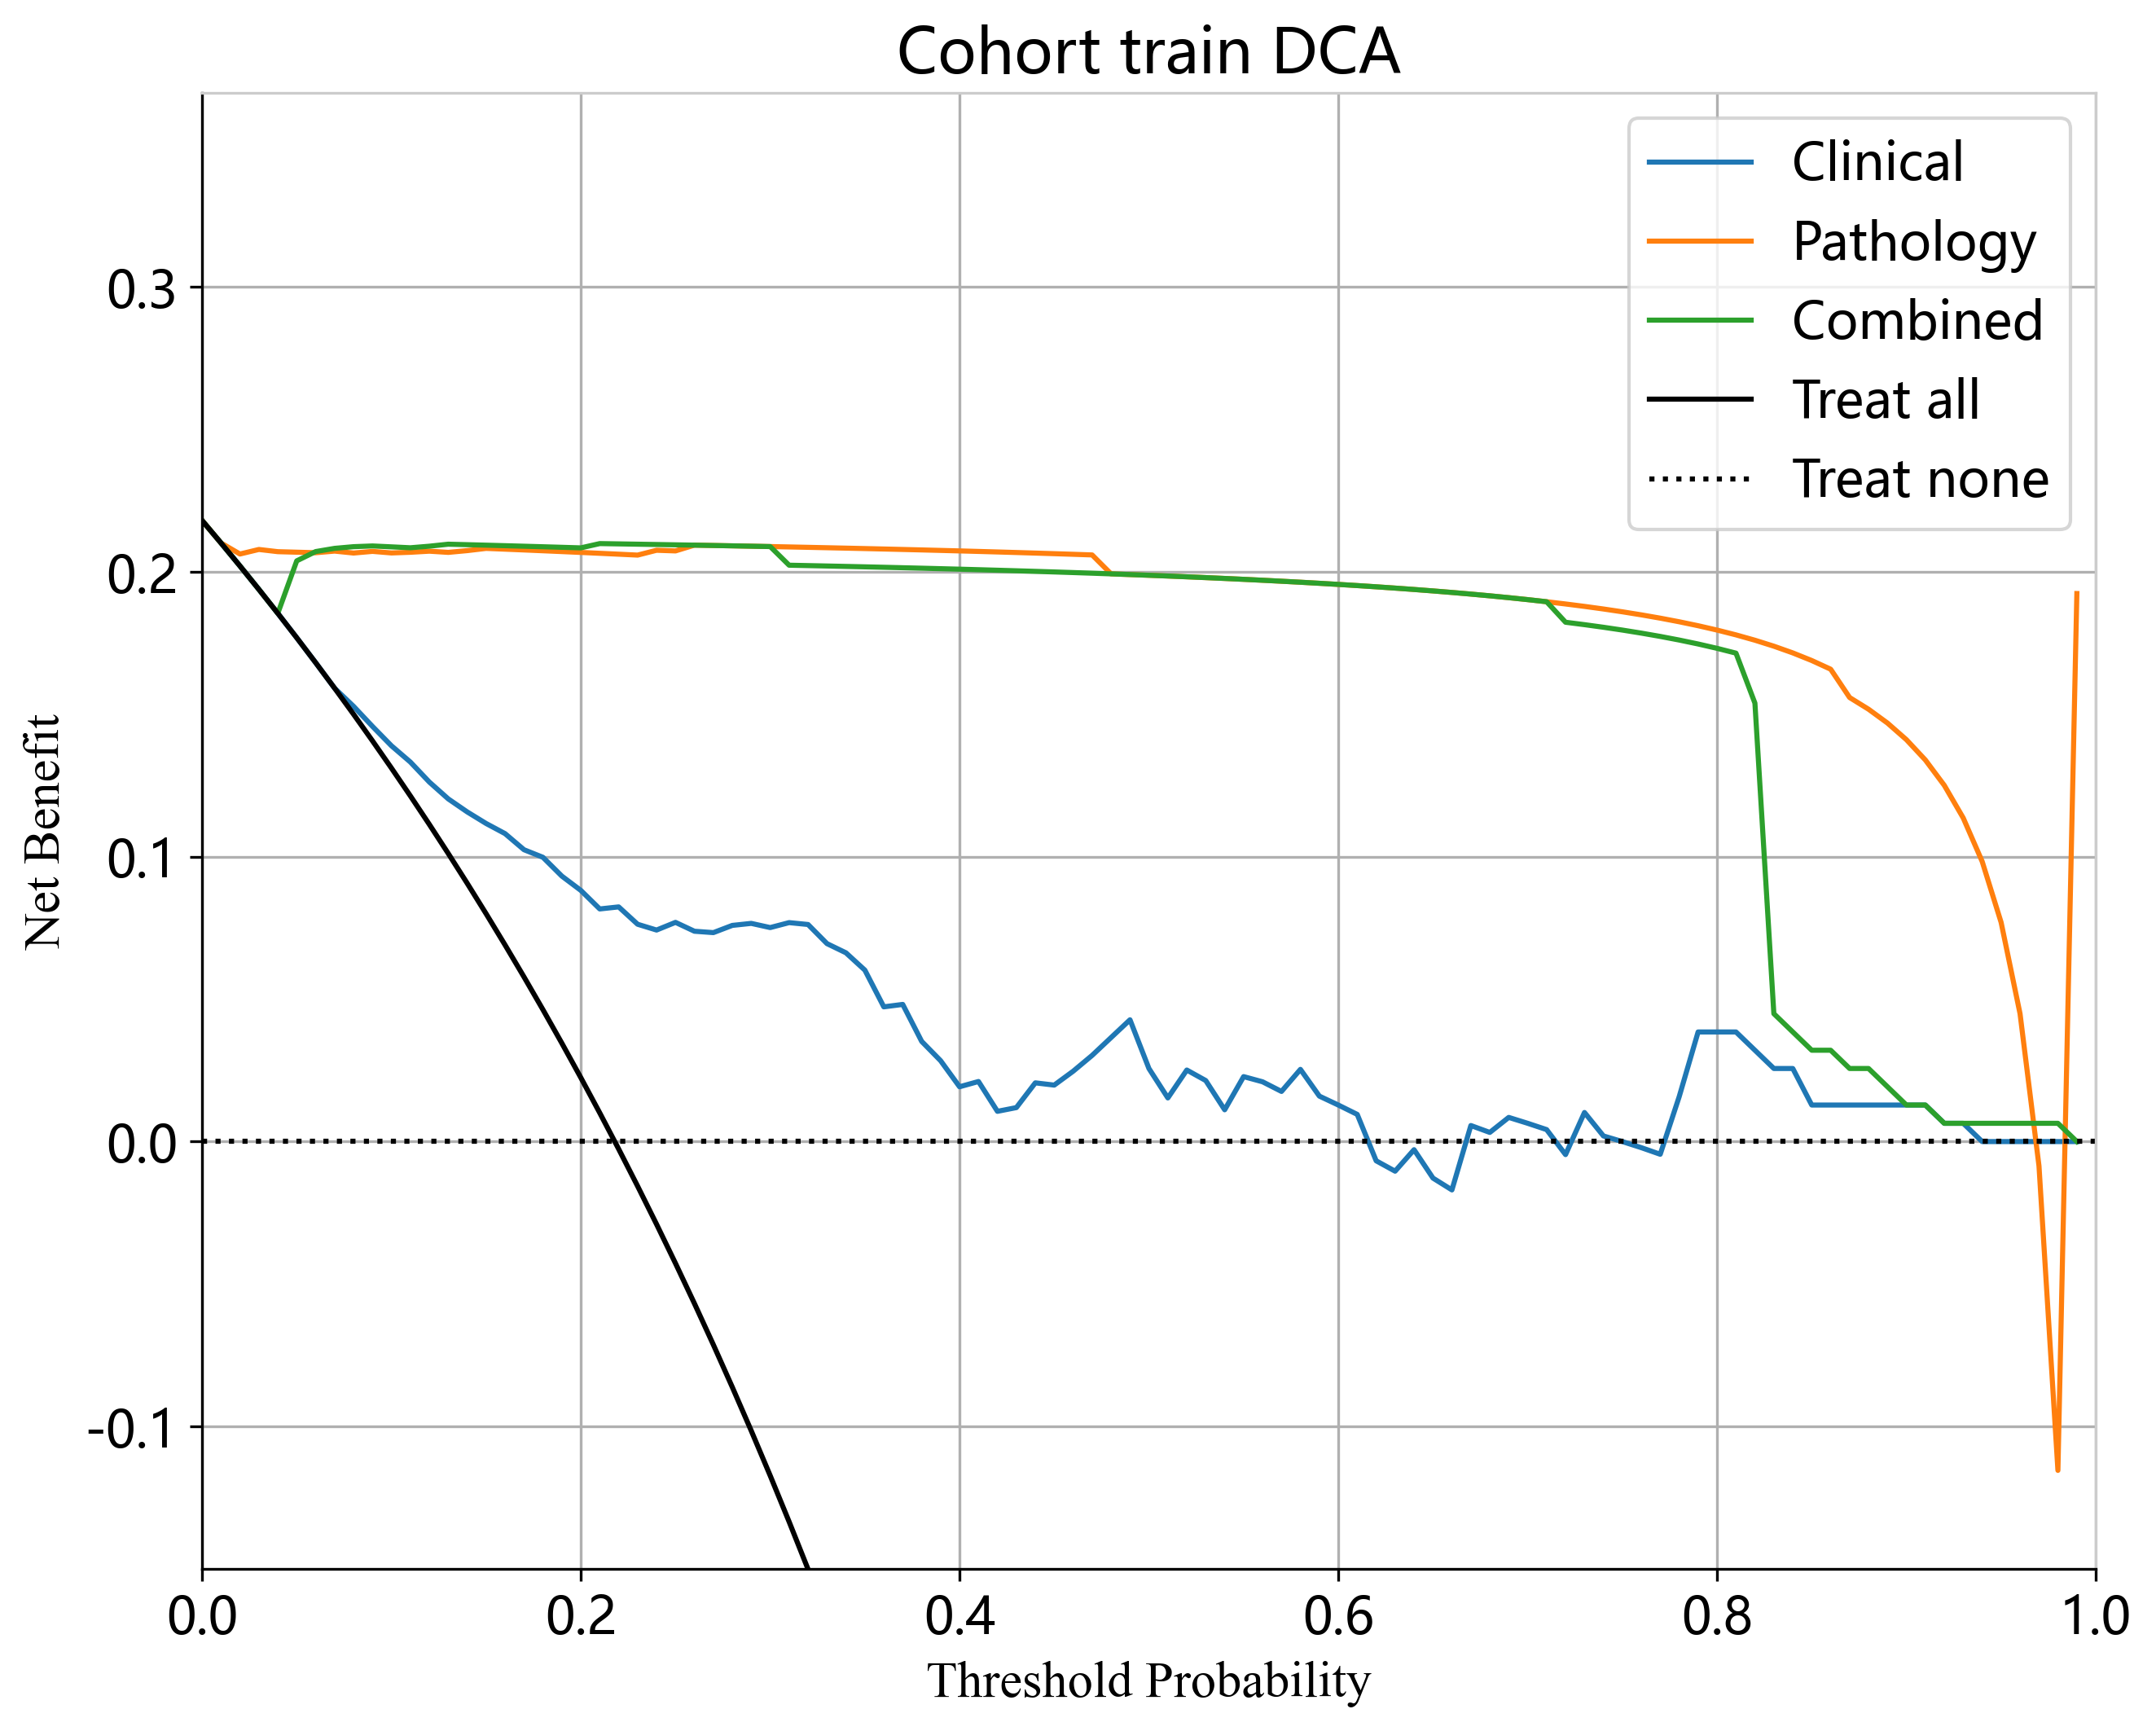

In [9]:
from onekey_algo.custom.components.comp1 import plot_DCA

plot_DCA([ALL_results[model_name] for model_name in model_names], 
         ALL_results[task], title=f'Cohort {subset} DCA', labels=model_names, y_min=-0.15)
plt.savefig(f'img/{subset}_dca.svg')

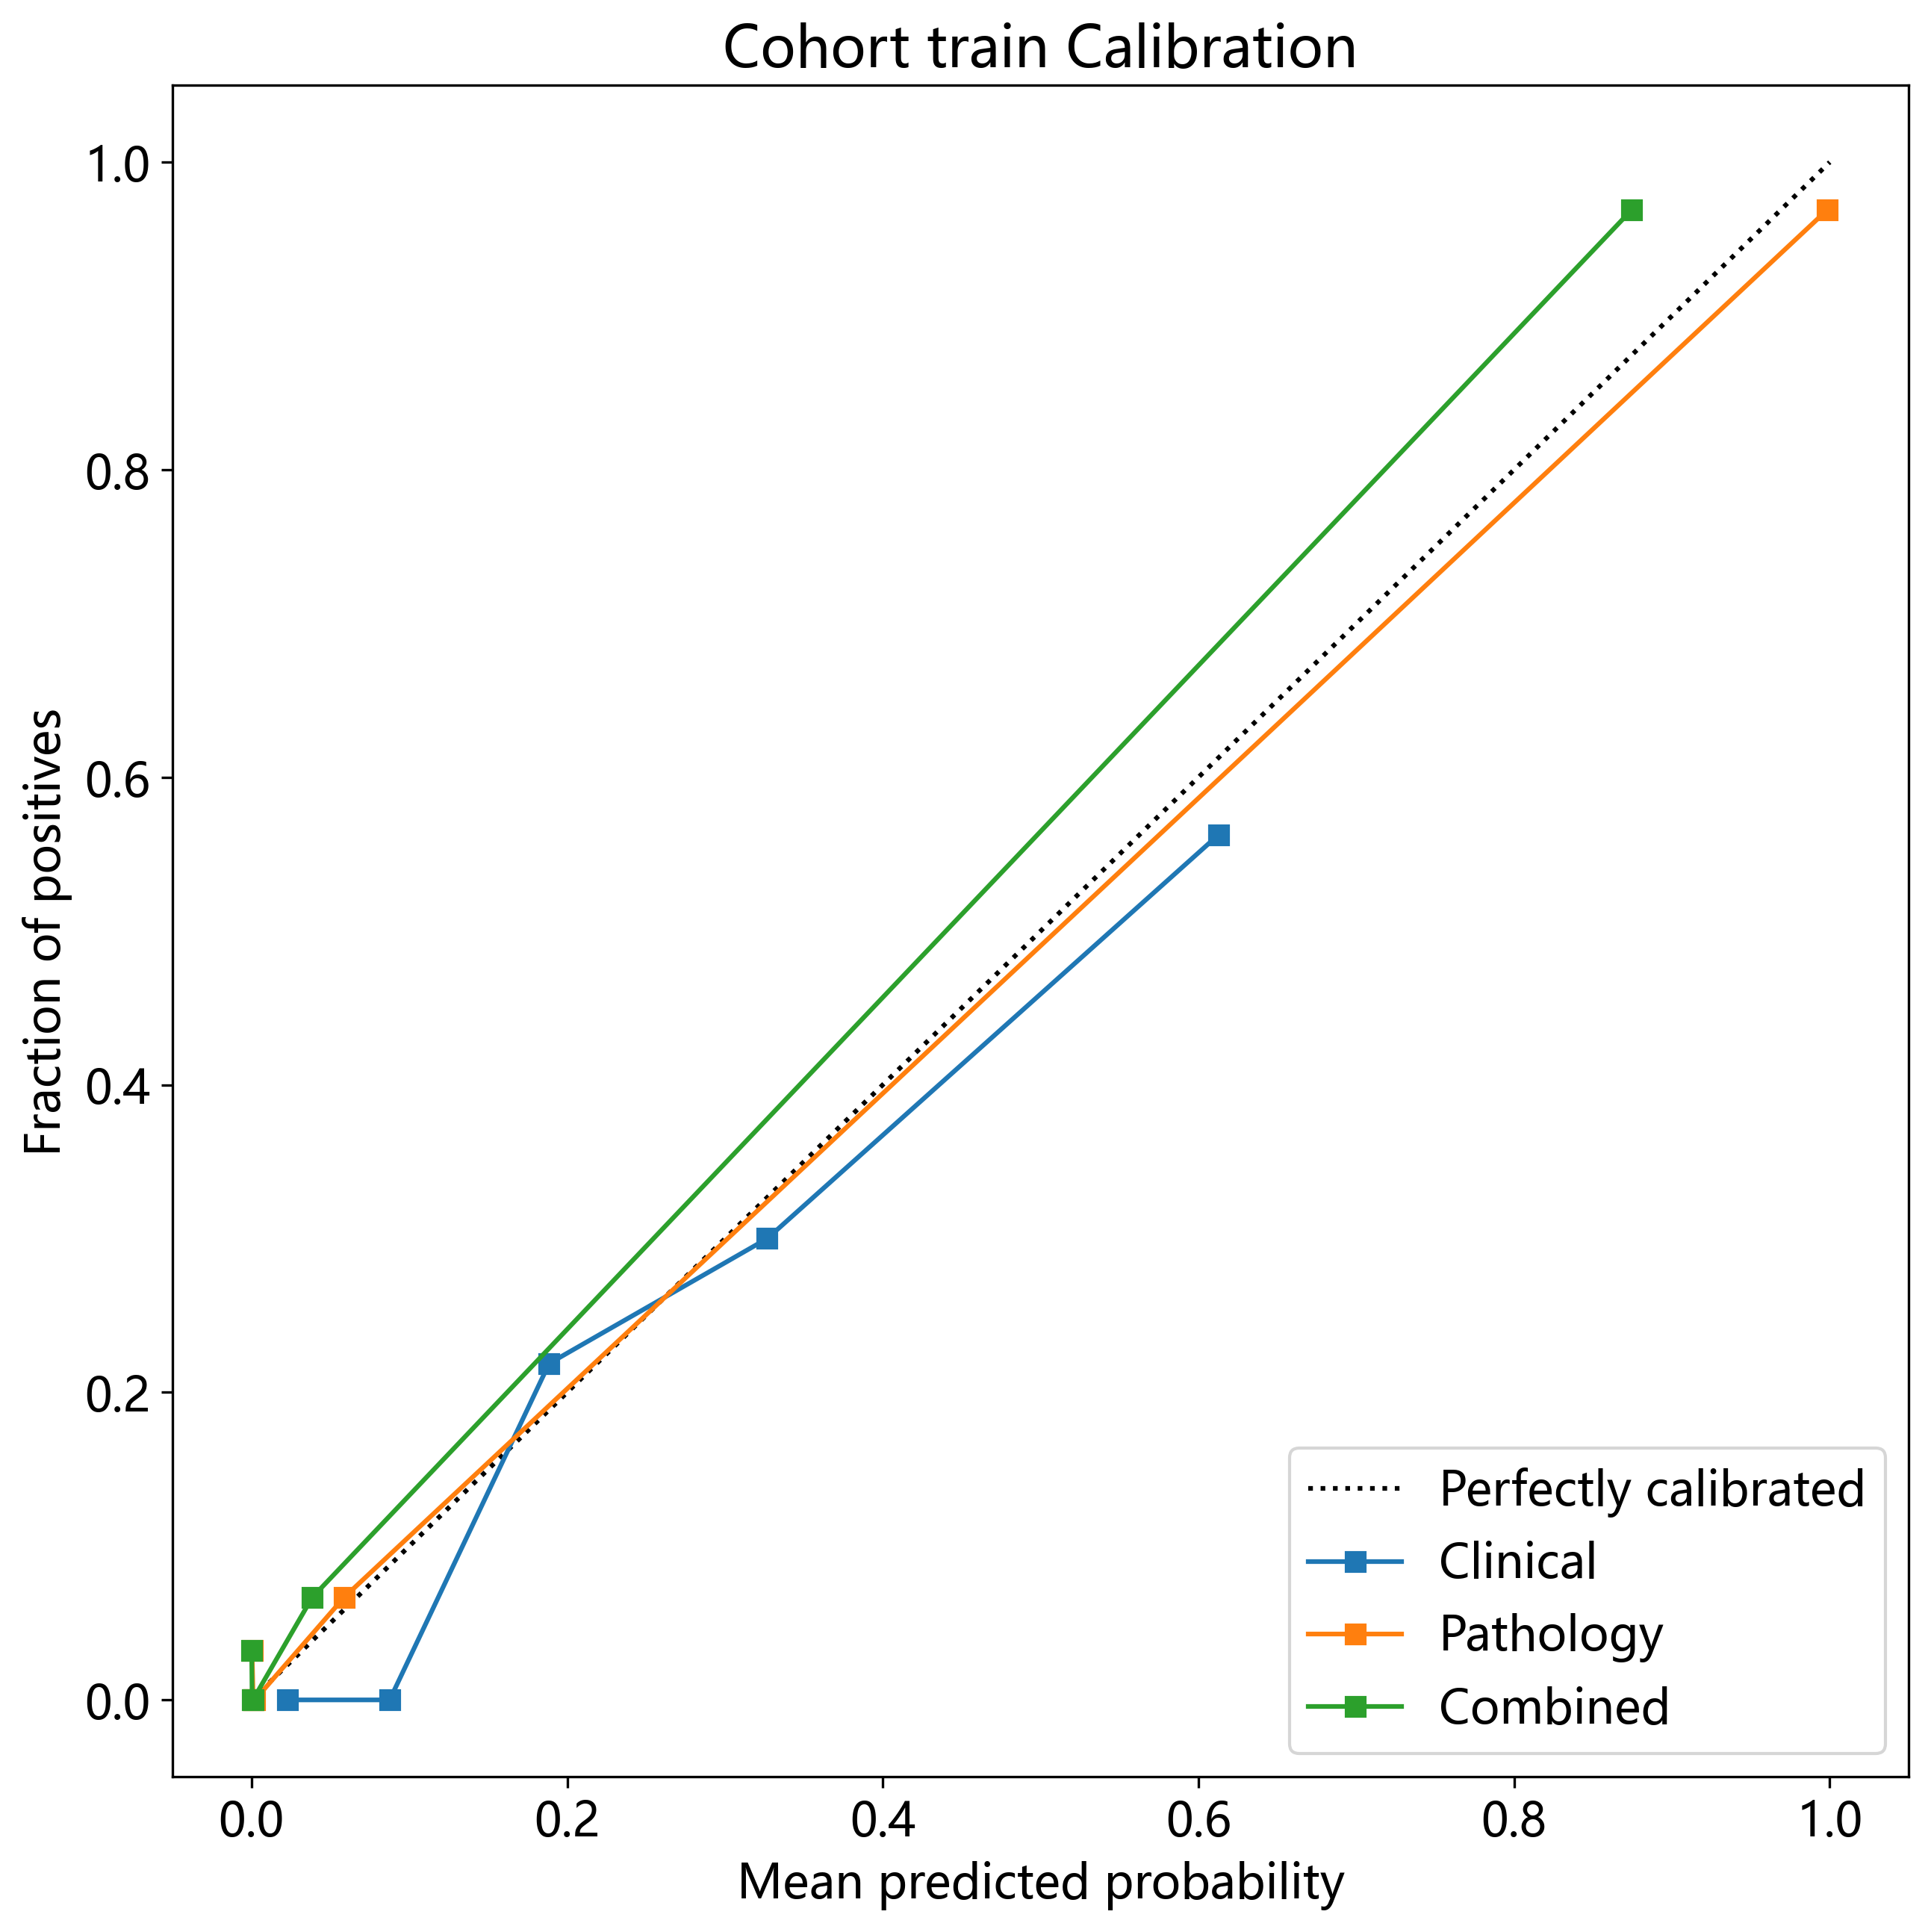

In [10]:
from onekey_algo.custom.components.comp1 import draw_calibration
draw_calibration(pred_scores=pred_train, n_bins=5, remap=True,
                 y_test=gt, model_names=model_names)
plt.title(f"Cohort {subset} Calibration")
plt.savefig(f'img/{subset}_cali.svg')

In [11]:
from onekey_algo.custom.components import stats

hosmer = []
hosmer.append([stats.hosmer_lemeshow_test(y_true, y_pred, remap=True, bins=25) 
              for fn, y_true, y_pred in zip(model_names, gt, pred_train)])
pd.DataFrame(hosmer, columns=model_names)

,Clinical,Pathology,Combined
0,0.327,0.961,0.838


[2023-12-28 12:19:32 - situation.py:  45]	INFO	cffi mode is CFFI_MODE.ANY
[2023-12-28 12:19:32 - situation.py: 189]	INFO	R home found: C:\OnekeyPlatform\onekey_envs\Lib\R
[2023-12-28 12:19:32 - situation.py: 136]	ERROR	Unable to determine R library path: Command '('C:\\OnekeyPlatform\\onekey_envs\\Lib\\R\\bin\\Rscript', '-e', 'cat(Sys.getenv("LD_LIBRARY_PATH"))')' returned non-zero exit status 1.
[2023-12-28 12:19:32 - situation.py: 147]	INFO	LD_LIBRARY_PATH: 
[2023-12-28 12:19:32 - embedded.py:  20]	INFO	Default options to initialize R: rpy2, --quiet, --no-save


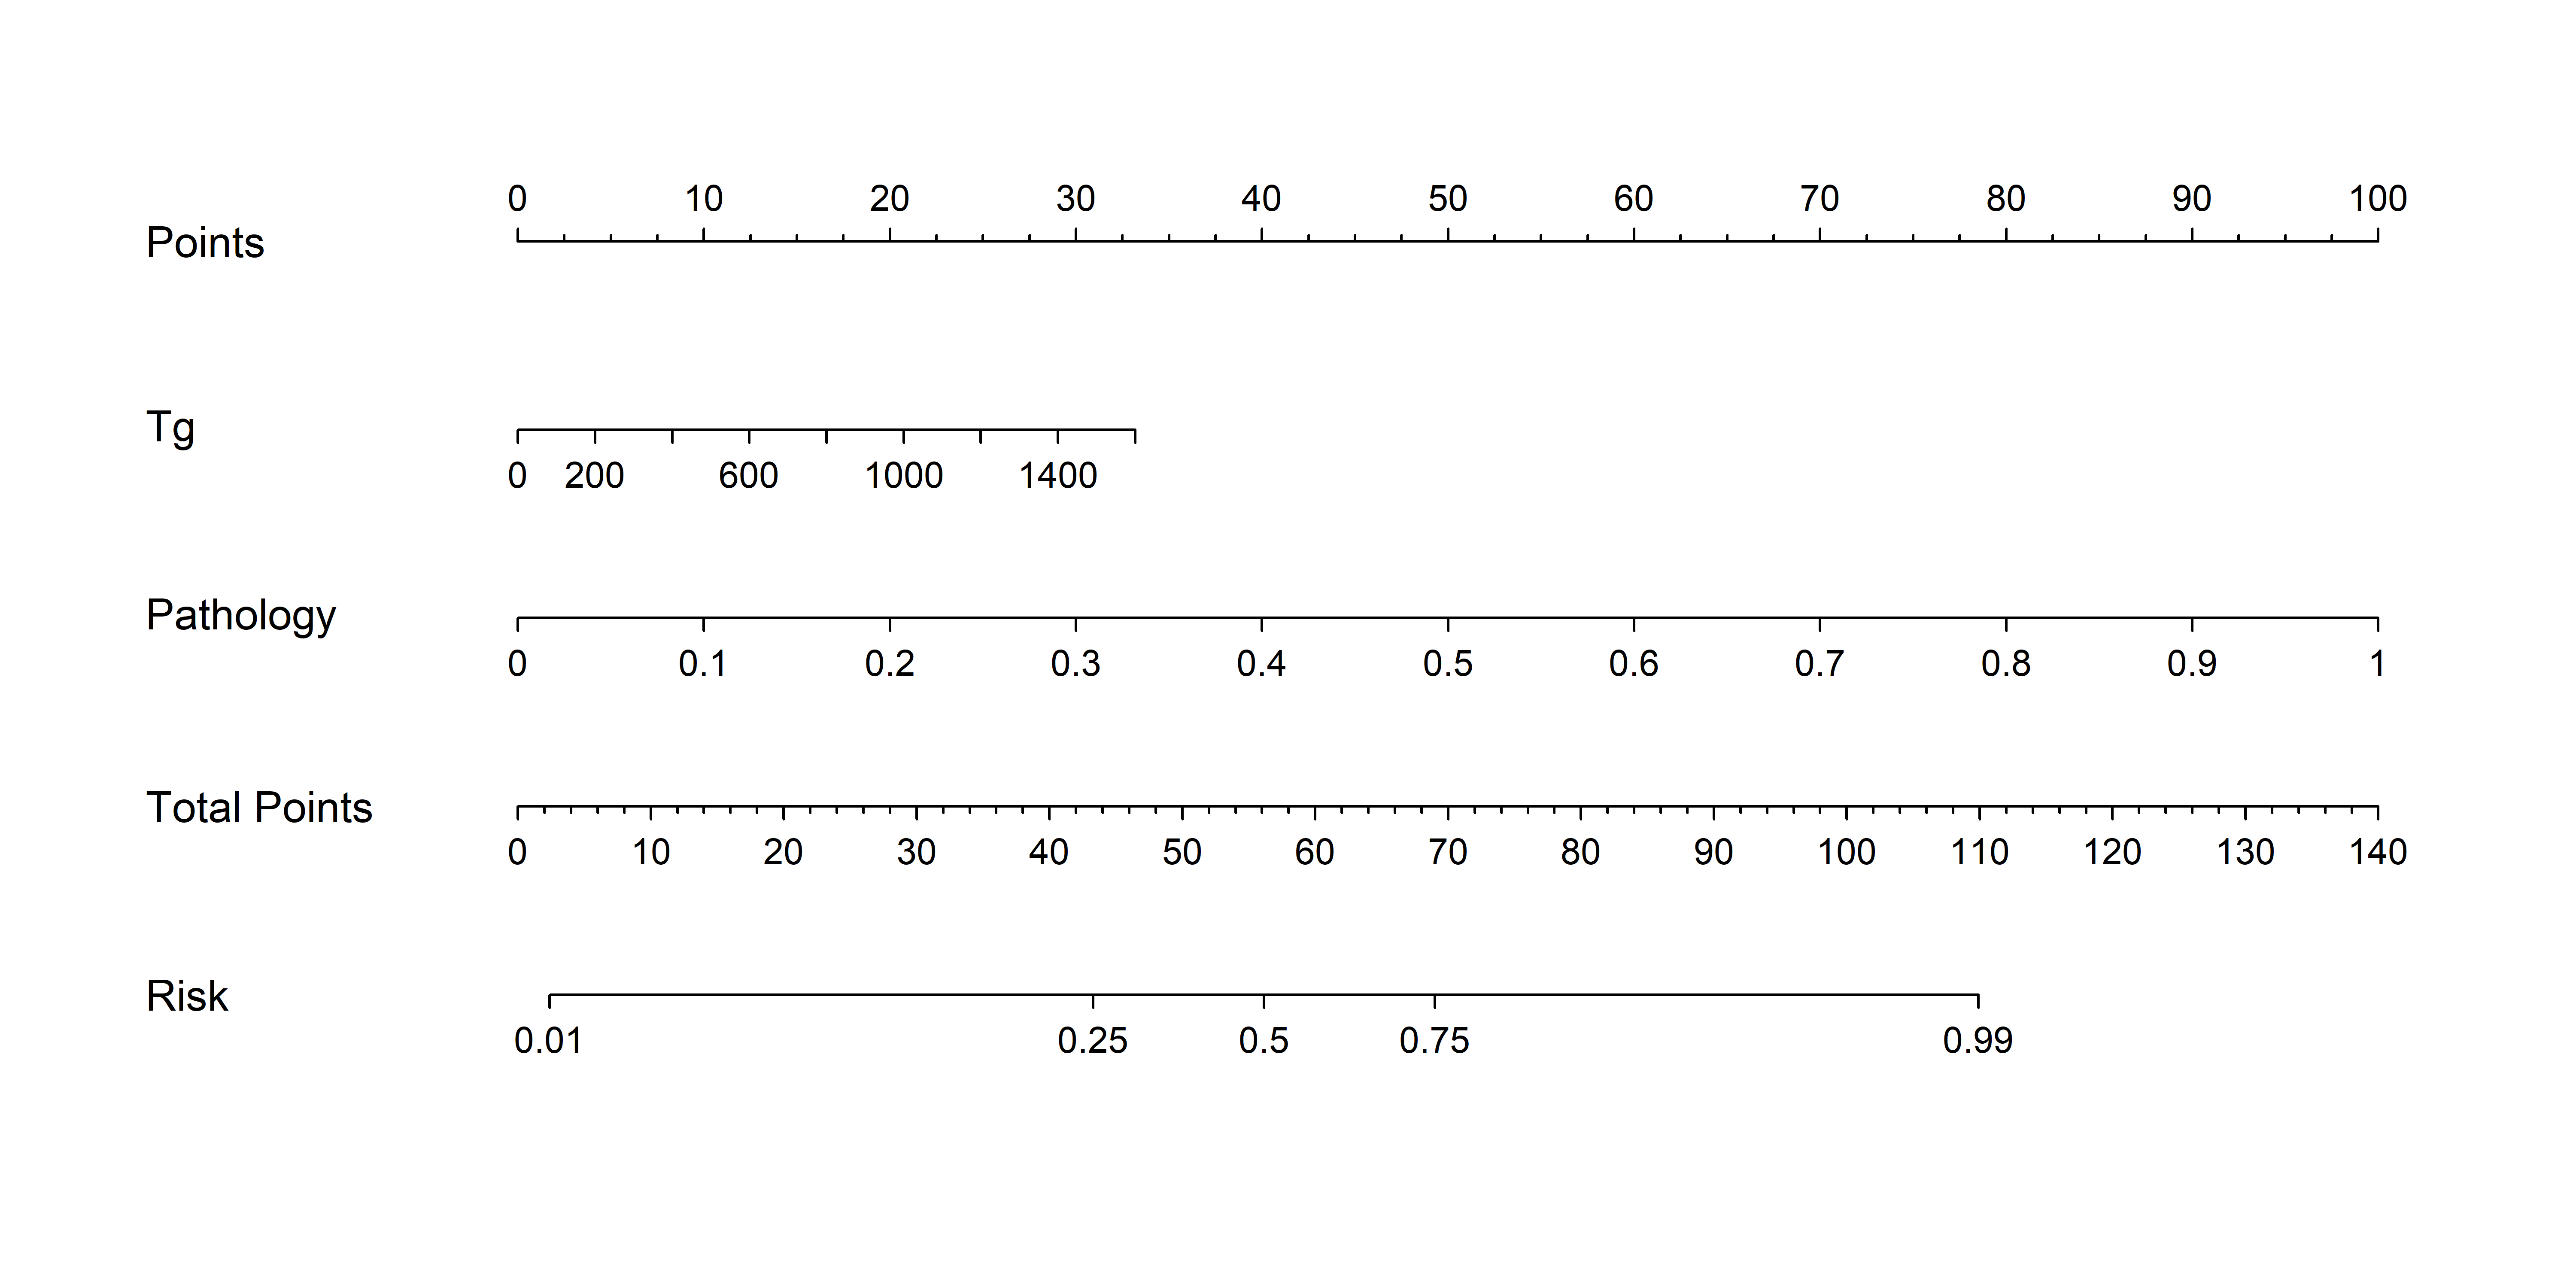

In [12]:
from onekey_algo.custom.components import nomogram
import shutil

ALL_results = ALL_results.round(decimals=2)
nomogram.risk_nomogram(ALL_results, result=task, 
                       columns=Clinic_features + [model_names[1]], width=6000, height=3000, x_range='0.01,0.25,0.5,0.75,0.99')

# 测试集-Nomogram

,ID,-0,Clinical,label,-00,Pathology,-l,Tg
0,4,0.593,0.407,0,0.986,0.014,0,21.08
1,10,0.925,0.075,0,0.979,0.021,0,0.38
2,12,0.466,0.534,0,0.973,0.027,0,8.89
3,14,0.742,0.258,0,0.987,0.013,0,10.64
4,15,0.220,0.780,1,0.748,0.252,1,184.50
...,...,...,...,...,...,...,...,...
63,217,0.408,0.592,0,0.561,0.439,0,6.22
64,218,0.510,0.490,0,0.977,0.023,0,1.56
65,232,0.903,0.097,0,0.978,0.022,0,0.78
66,233,0.274,0.726,0,0.982,0.018,0,3.57


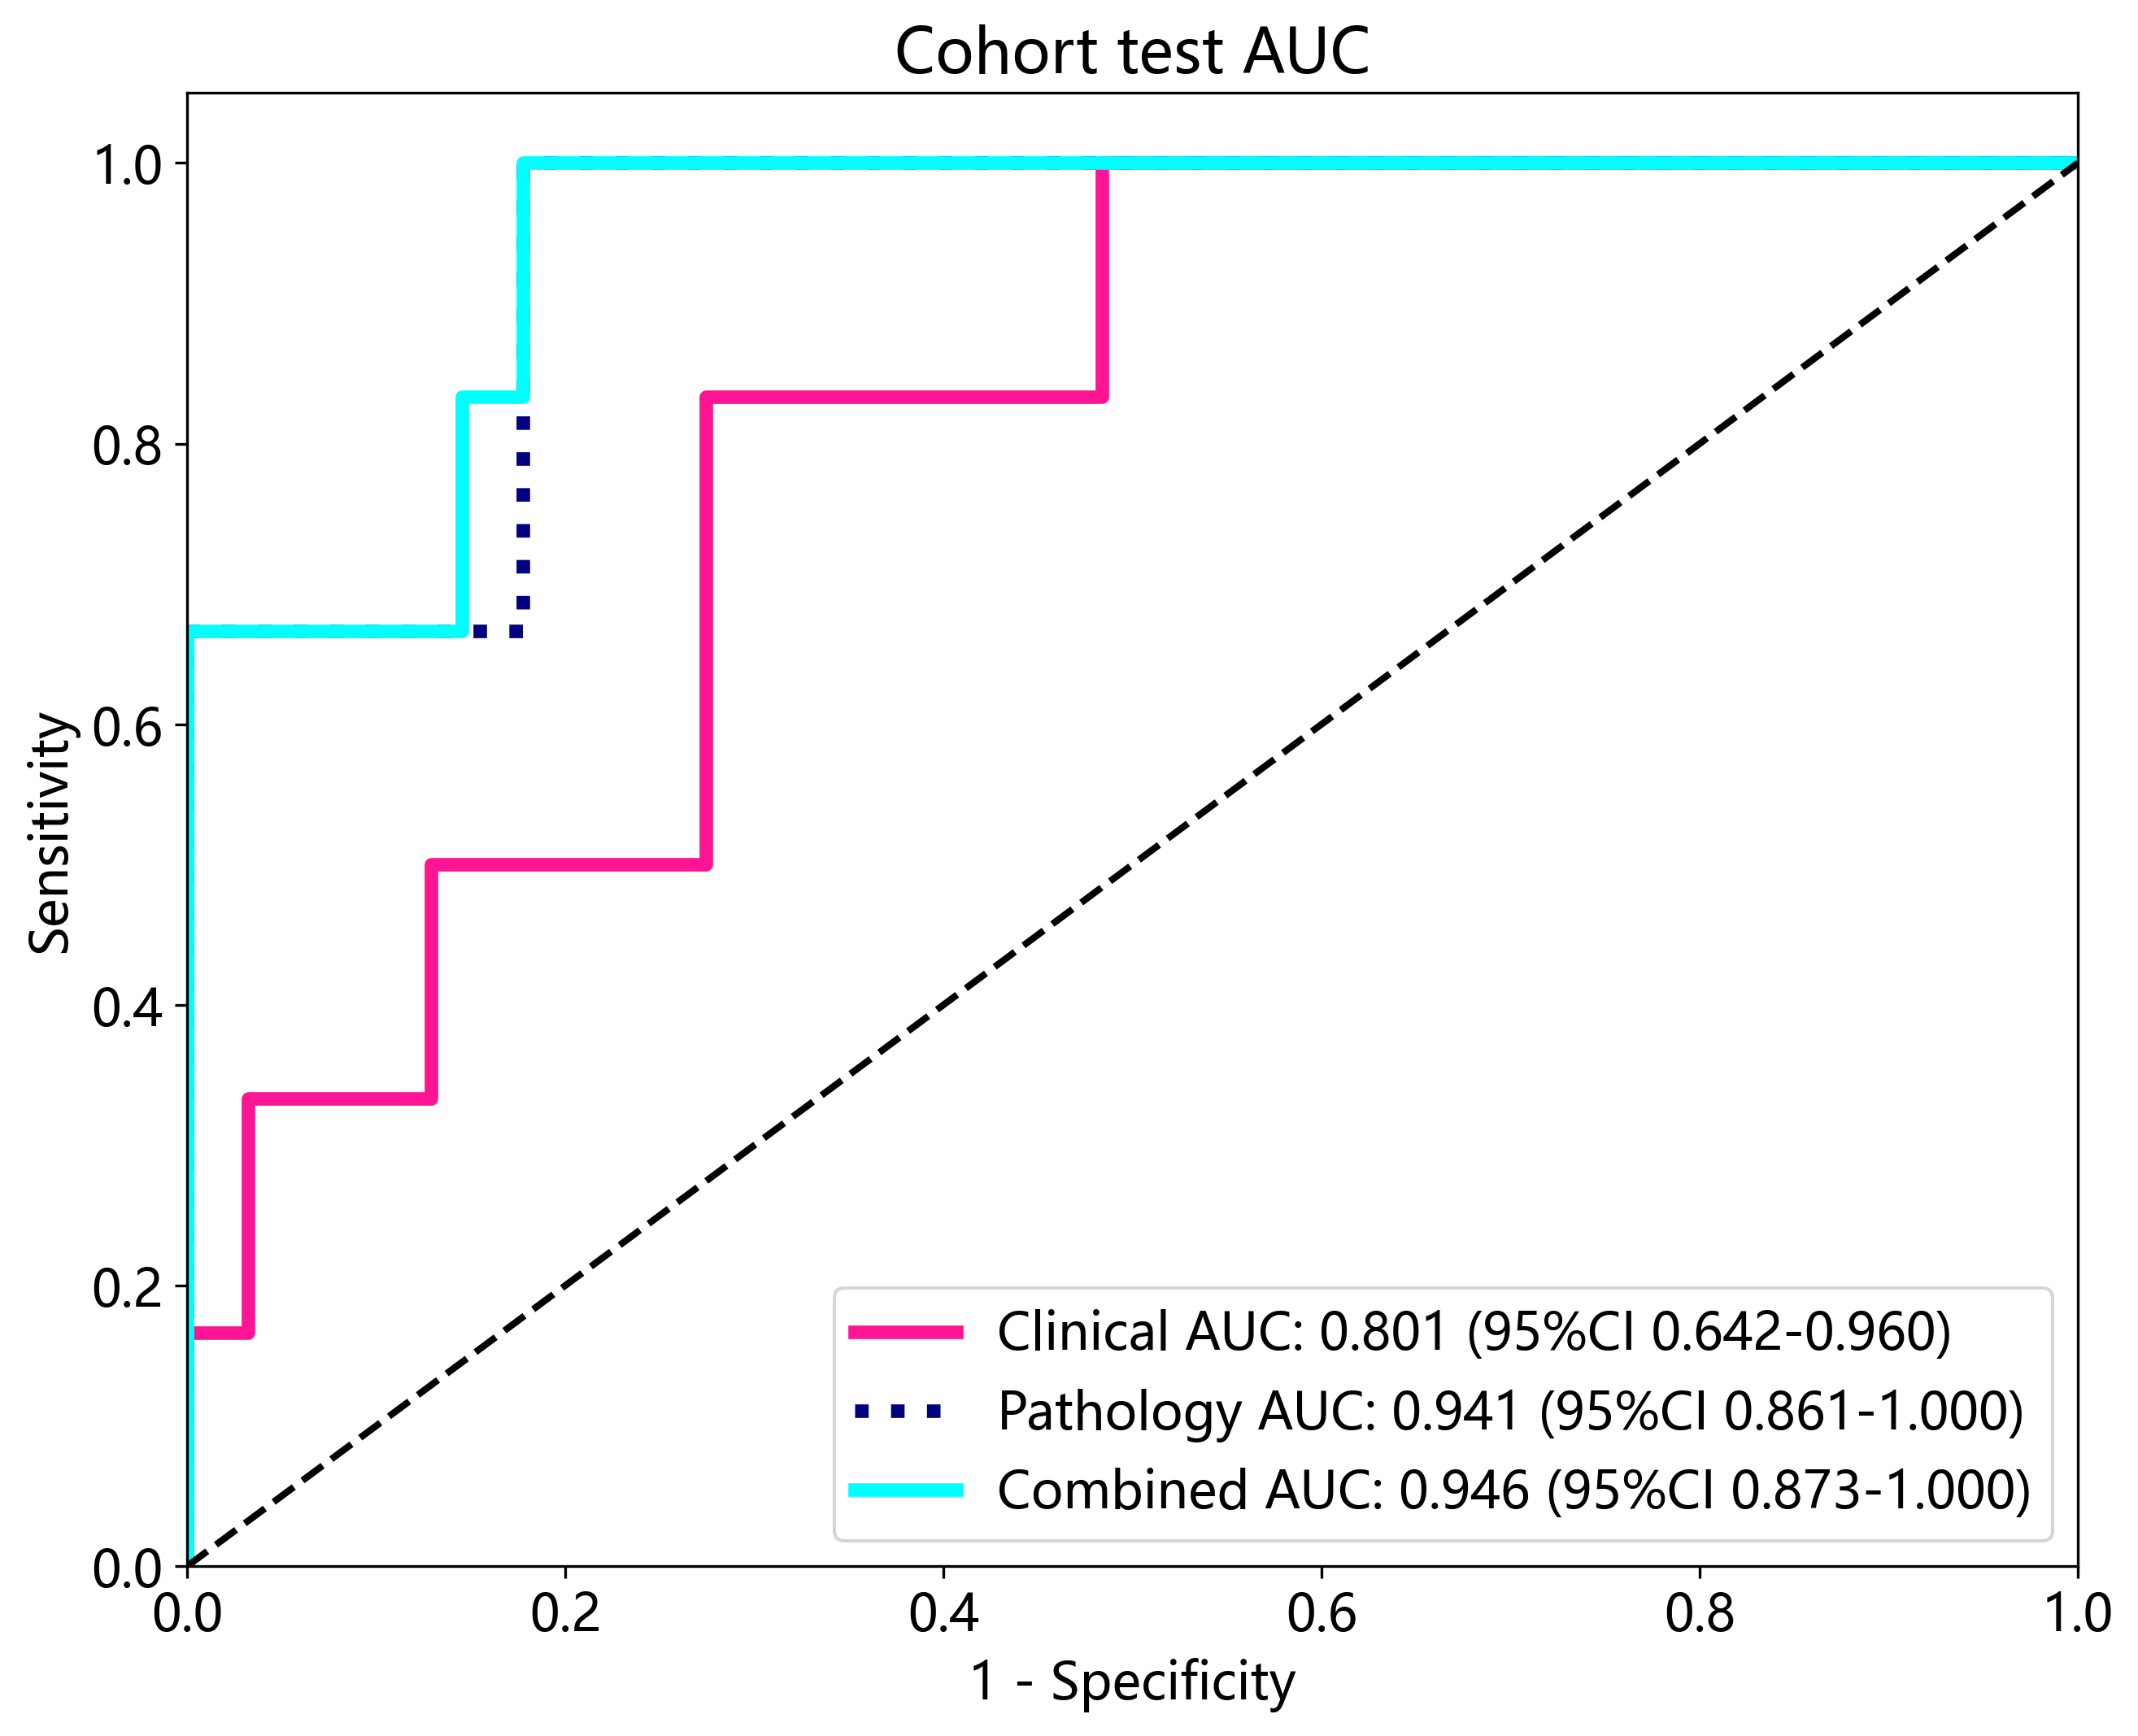

,Signature,Accuracy,AUC,95% CI,Sensitivity,Specificity,PPV,NPV,Precision,Recall,F1,Threshold,Cohort
0,Clinical,0.808,0.870,0.8132 - 0.9260,0.618,0.861,0.553,0.890,0.553,0.618,0.583,0.348,Train
1,Pathology,0.981,0.970,0.9126 - 1.0000,0.941,0.992,0.970,0.984,0.970,0.941,0.955,0.477,Train
2,Combined,0.981,0.973,0.9201 - 1.0000,0.941,0.992,0.970,0.984,0.970,0.941,0.955,0.303,Train
3,Clinical,0.662,0.801,0.6418 - 0.9604,0.833,0.645,0.185,0.976,0.185,0.833,0.303,0.534,test
4,Pathology,0.882,0.941,0.8609 - 1.0000,0.667,0.903,0.400,0.966,0.400,0.667,0.500,0.243,test
5,Combined,0.912,0.946,0.8728 - 1.0000,0.667,0.935,0.500,0.967,0.500,0.667,0.571,0.125,test


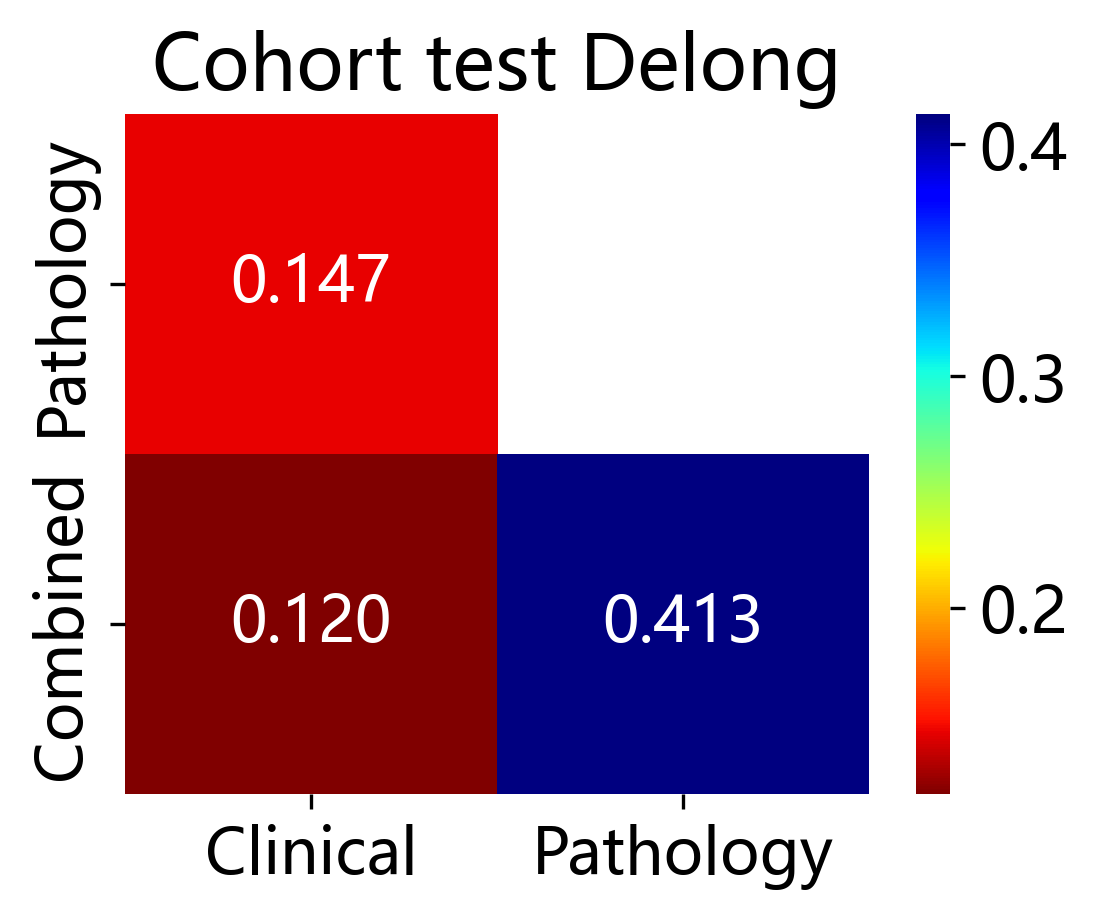

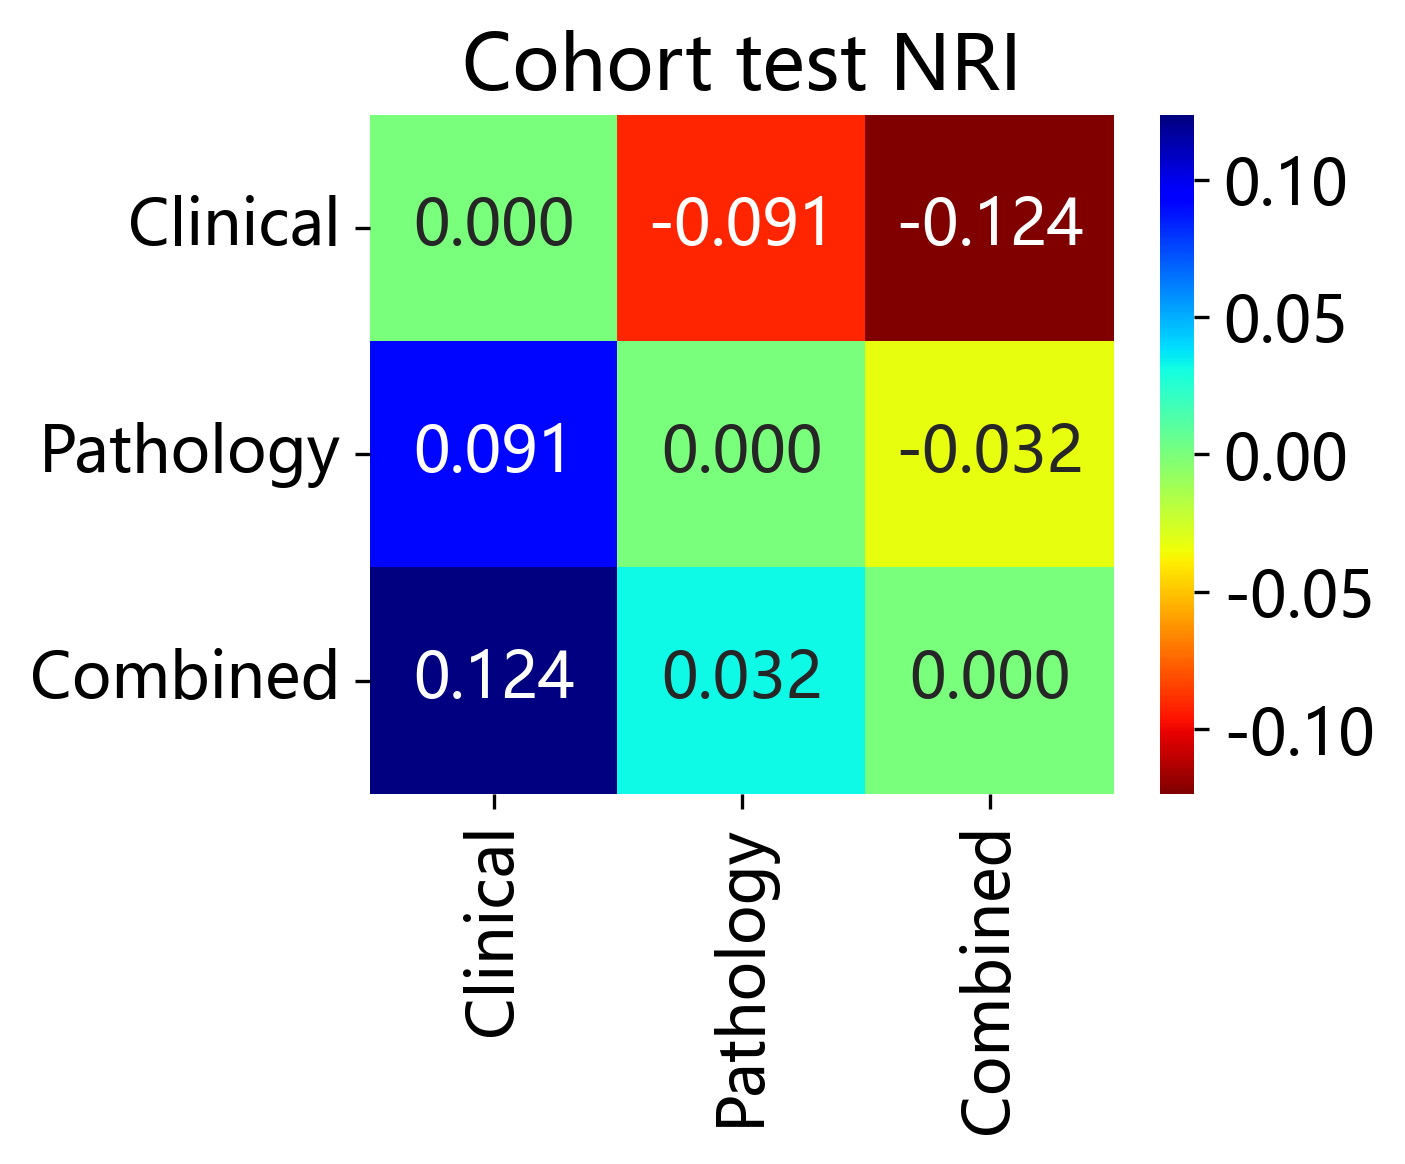

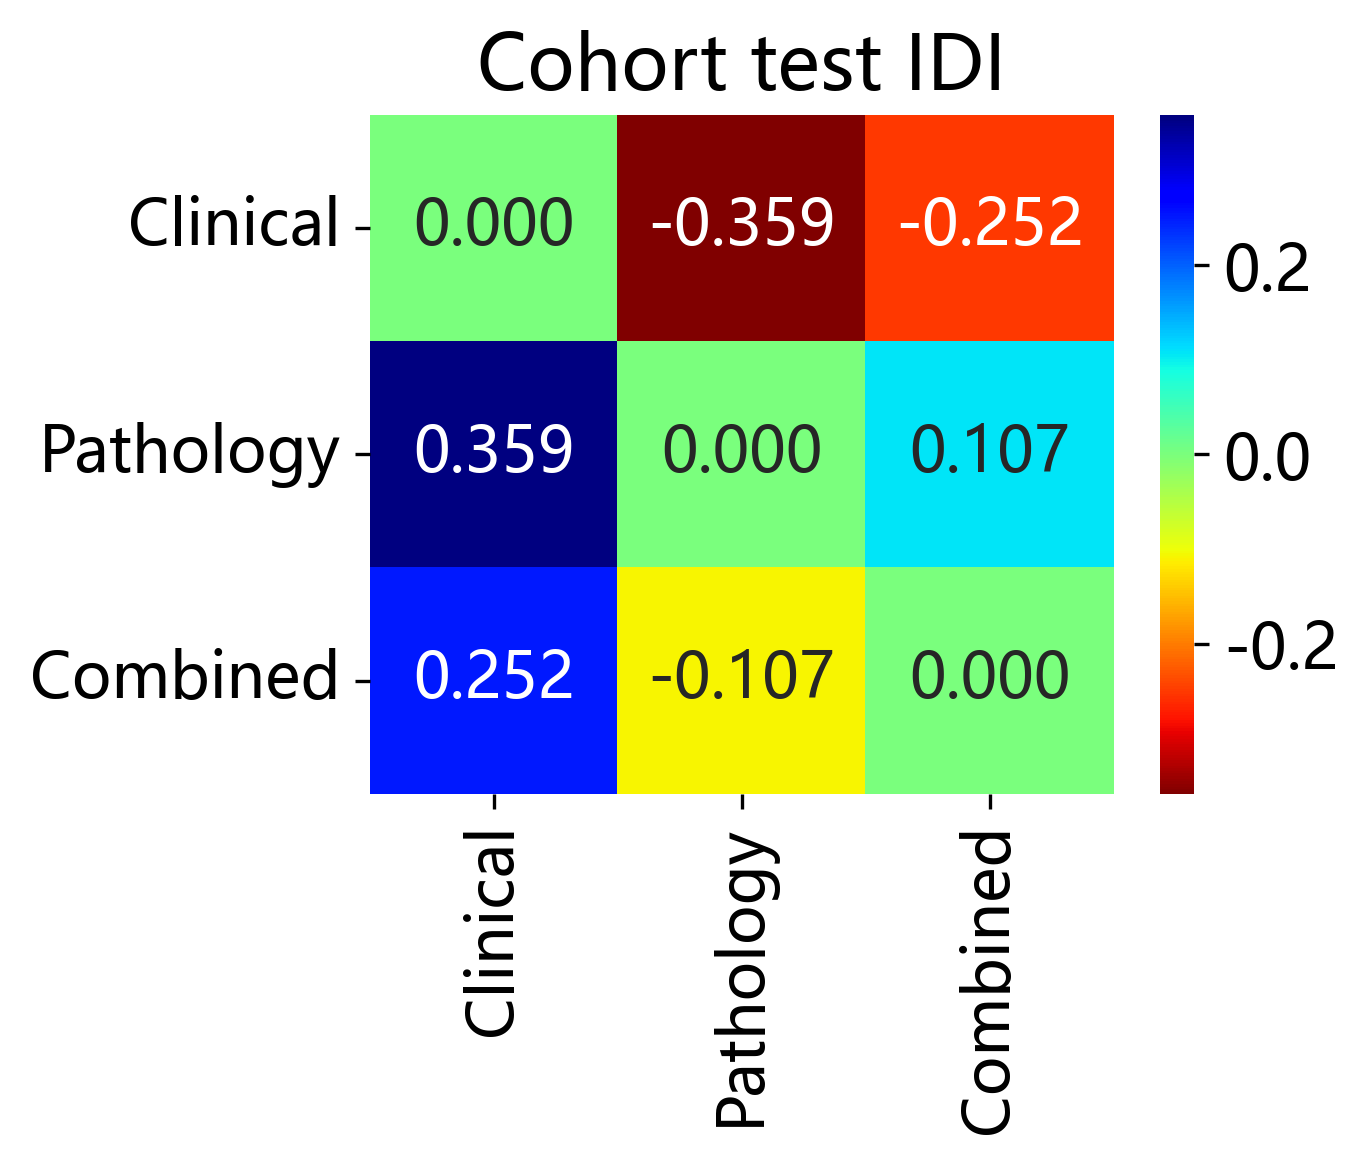

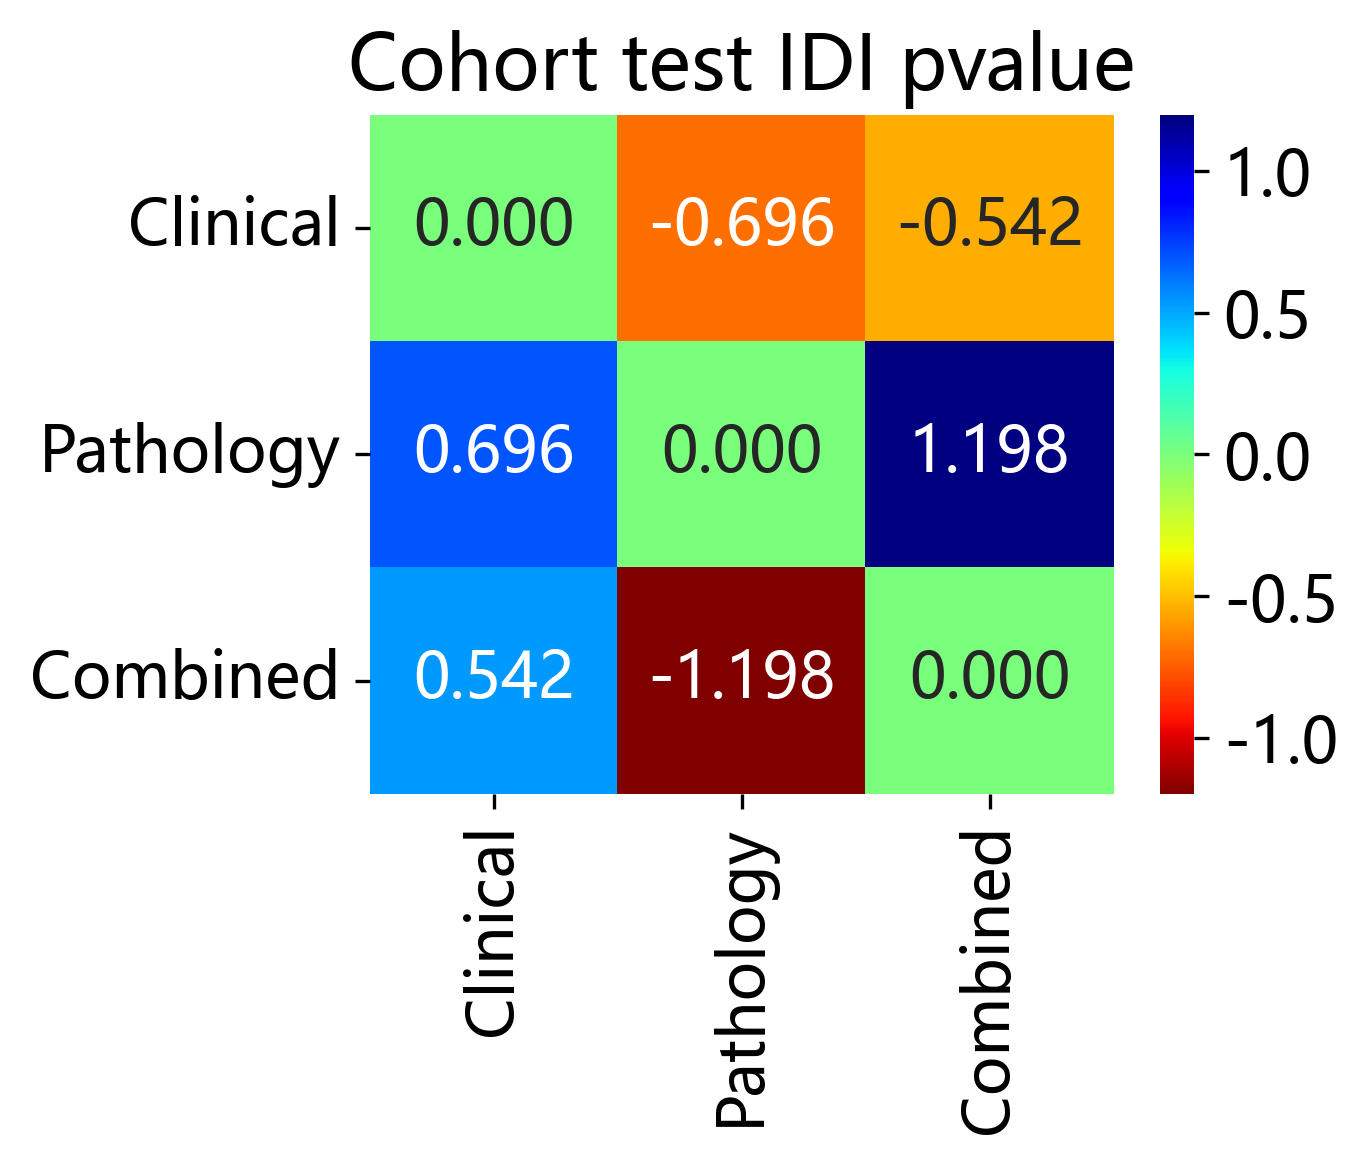

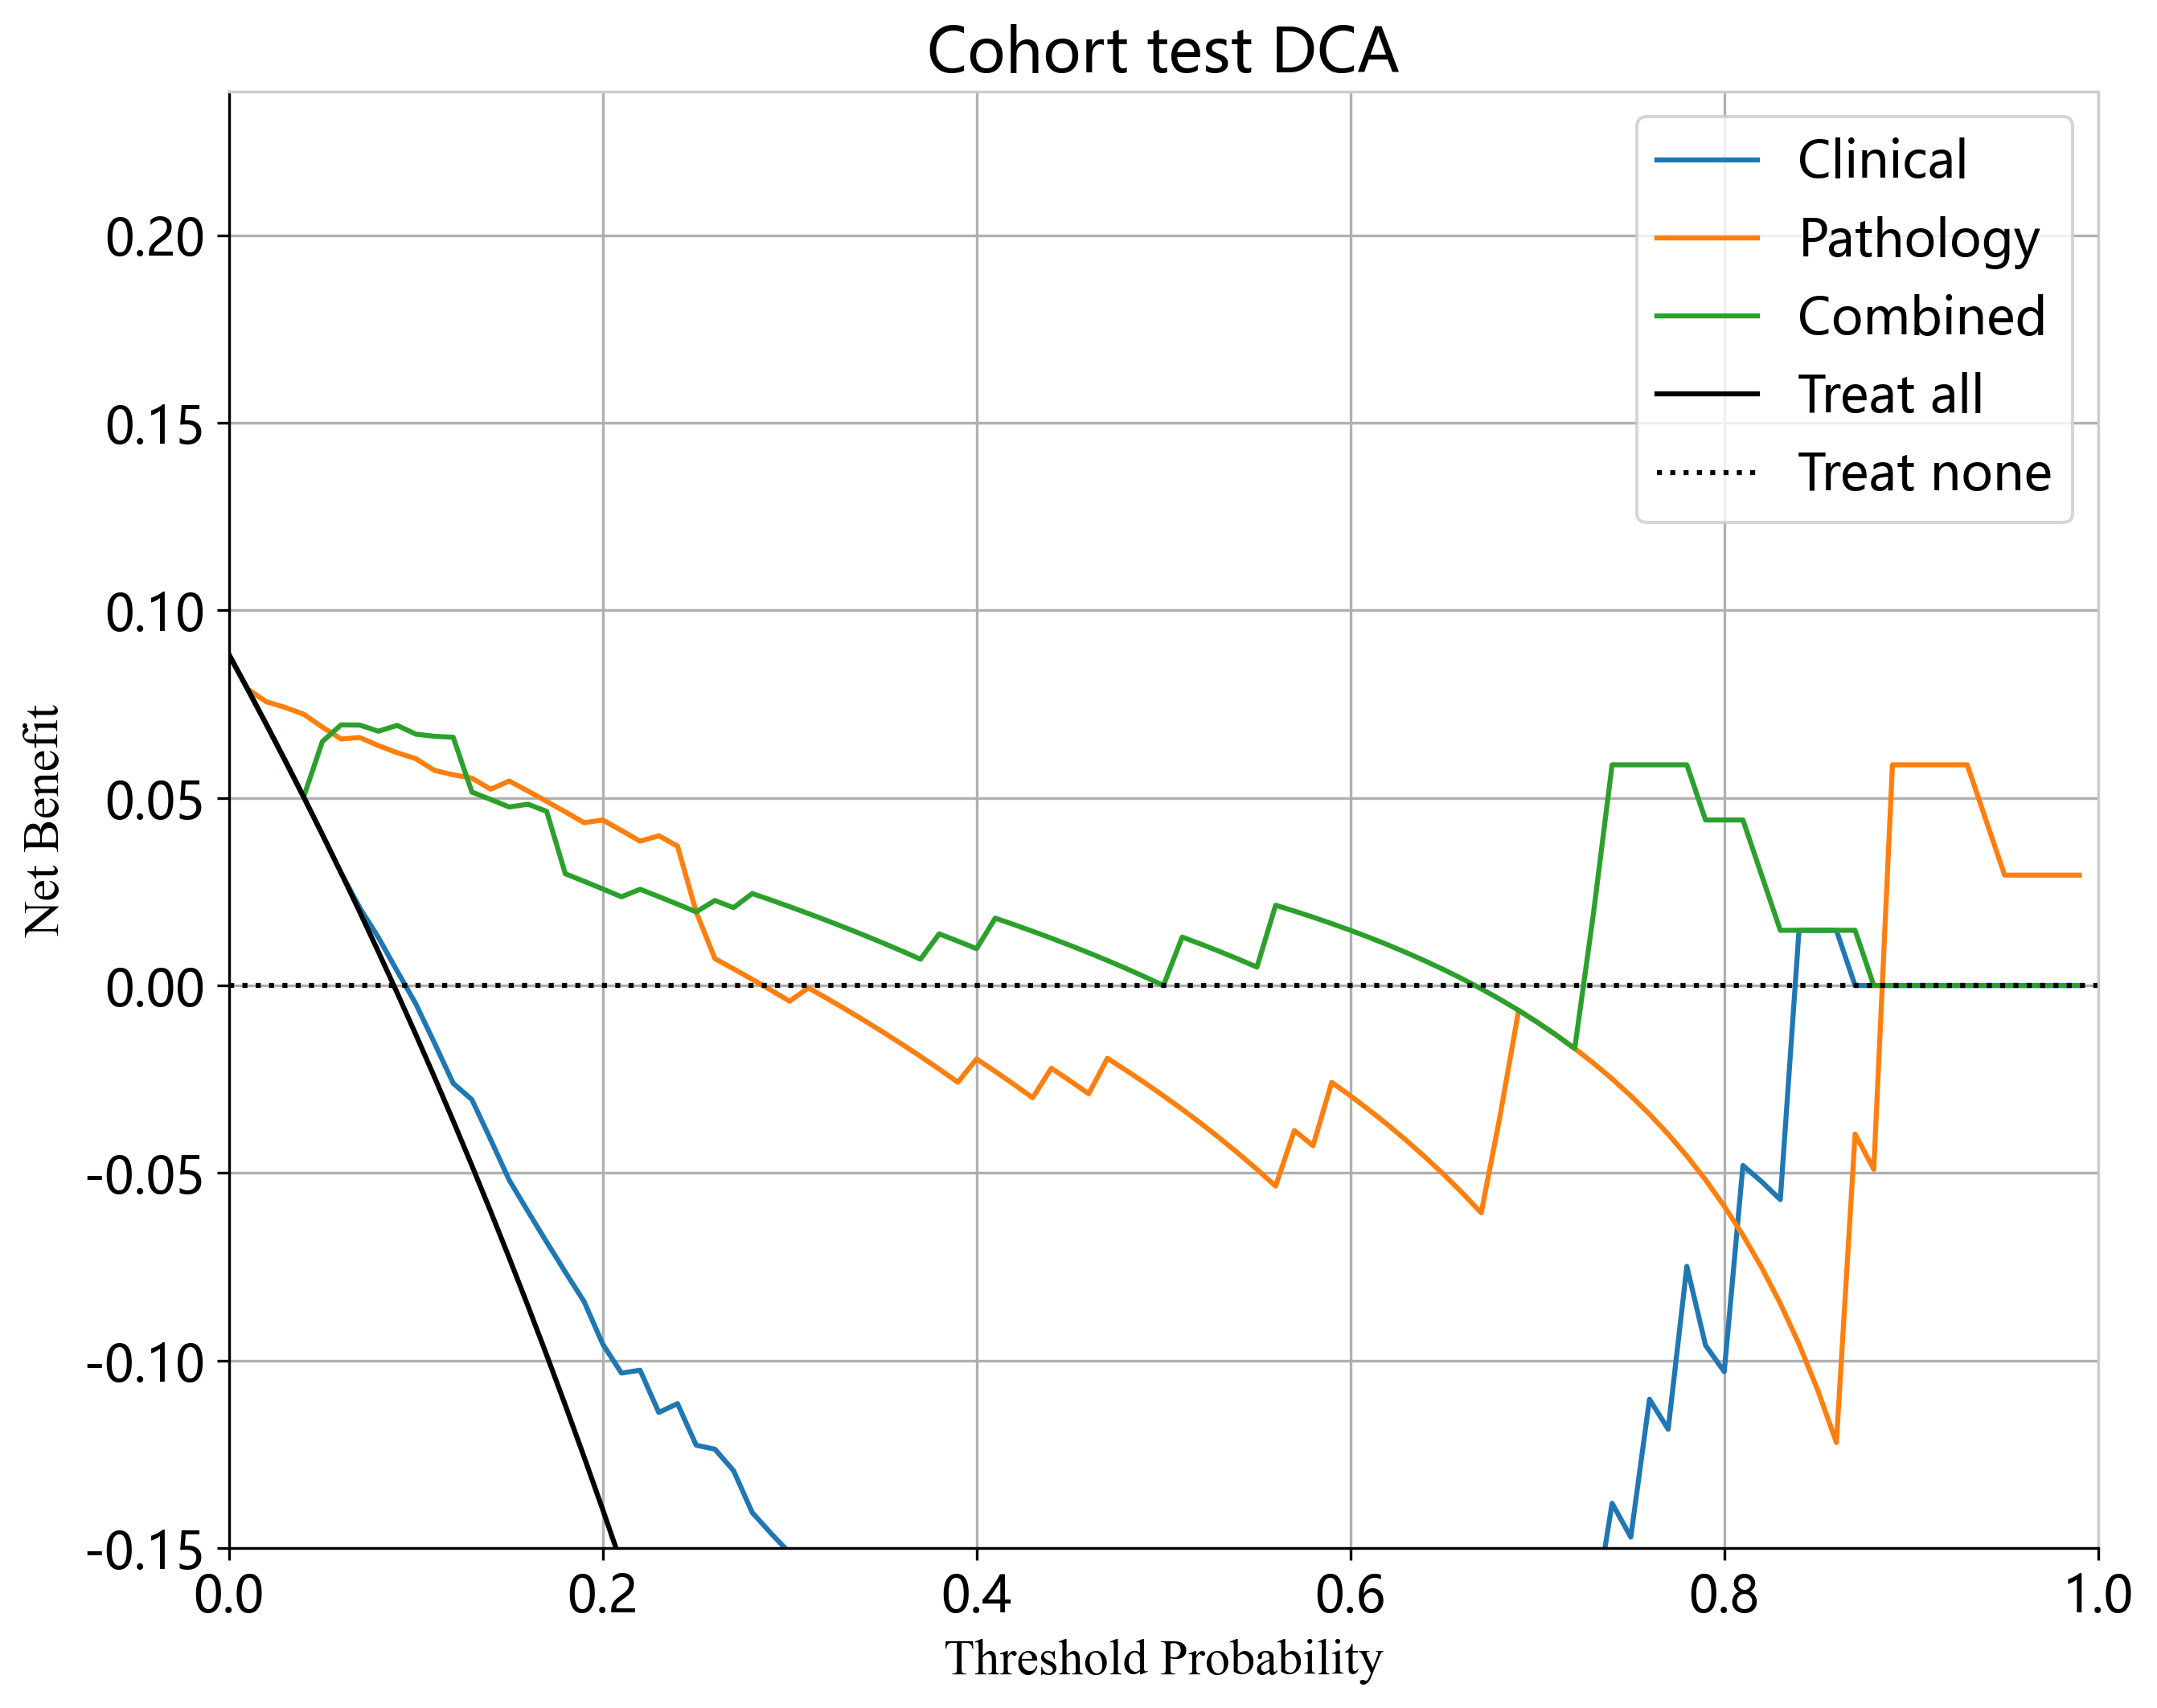

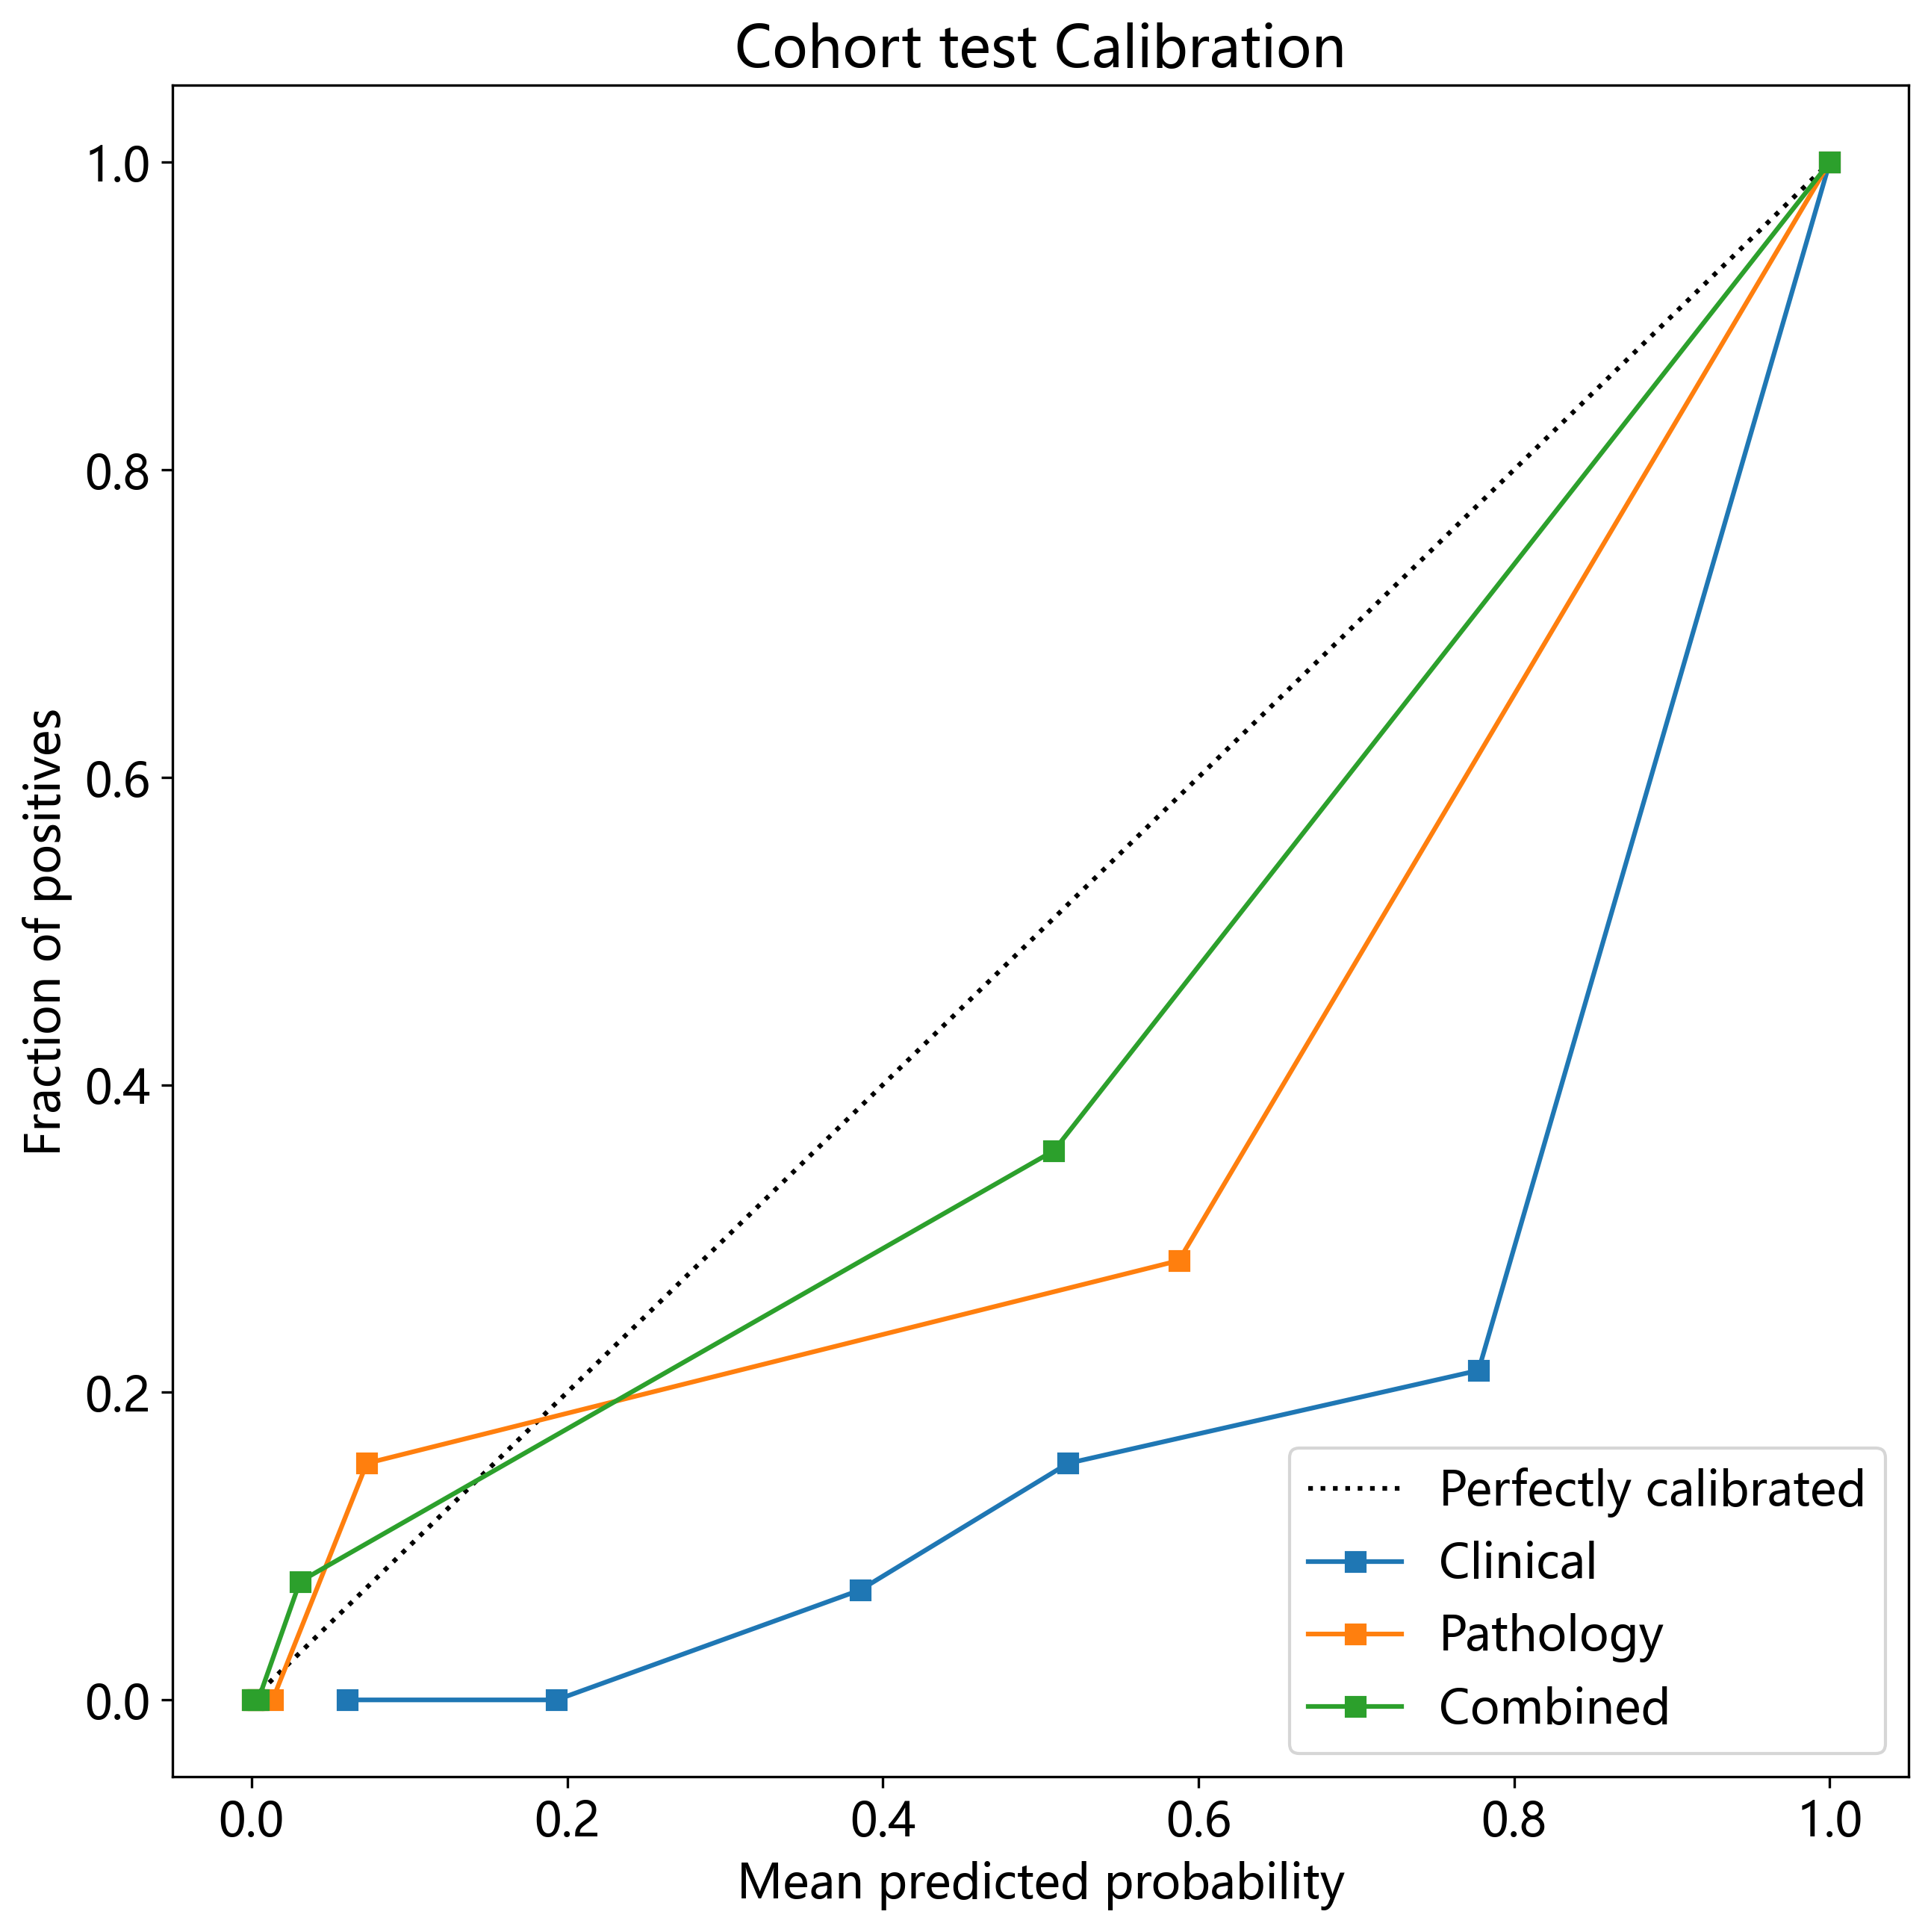

,Clinical,Pathology,Combined
0,0.327,0.961,0.838
1,0.712,0.173,0.350


In [13]:
import pandas as pd
from onekey_algo.custom.components.comp1 import normalize_df
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from onekey_algo.custom.components import metrics
from onekey_algo.custom.components.delong import delong_roc_test
from onekey_algo.custom.components.comp1 import draw_matrix
from onekey_algo.custom.components.metrics import NRI, IDI
from onekey_algo.custom.components.comp1 import plot_DCA
from onekey_algo.custom.components.comp1 import draw_calibration
from onekey_algo.custom.components import stats

for subset in ['test']:
    Clinic_results = pd.merge(pd.read_csv(f'./results/Clinical_LightGBM_{subset}.csv', header=0), label_data, on='ID', how='inner')
    DTL_results = pd.merge(pd.read_csv(f'./results/Path_LR_{subset}.csv', header=0), label_data, on='ID', how='inner')

    ALL_results = pd.merge(Clinic_results, DTL_results, on='ID', how='inner')
    ALL_results.columns = ['ID', '-0', model_names[0], task, '-00', model_names[1], '-l']
    Clinic = pd.read_csv('clinic_sel.csv')
    Clinic_features = [c for c in Clinic.columns if c not in ['ID', task, group_info]]
    Clinic = Clinic[['ID'] + Clinic_features]
    # ALL_results = normalize_df(ALL_results, not_norm=['ID'], method='minmax')
    ALL_results = pd.merge(ALL_results, Clinic, on='ID', how='inner')
    ALL_results = ALL_results.dropna(axis=1)
    display(ALL_results)
    
    # 计算Combined
#     model = LogisticRegression(penalty='none')
    # model = SVC(probability=True, random_state=0)
    data_x = ALL_results[Clinic_features + [model_names[1]]]
#     data_x = ALL_results[model_names[:2]]
    data_y = ALL_results[task]
#     model.fit(data_x, data_y)
    joblib.dump(model, f'models/Nomogram_LR_{subset}.pkl') 
    results = model.predict_proba(data_x)
    results = pd.DataFrame(results, index=ALL_results['ID'], columns=[f'{task}-0', f'{task}-1']).reset_index()
    results.to_csv(f'./results/Nomo_{subset}.csv', index=False, header=True)
    
    # 绘制整体的ROC曲线
    results.columns = ['ID', '-', model_names[-1]]
    ALL_results = pd.merge(ALL_results, results, on='ID', how='inner')
    gt = [np.array(ALL_results[task]) for d in model_names]
    pred_train = [np.array(ALL_results[d]) for d in model_names]
    okcomp.comp1.draw_roc(gt, pred_train, labels=model_names, title=f"Cohort {subset} AUC", auto_point=True,
                          markers=[ '.', ',', 'o', '.', ',', 'o', ], point_colors=['red', 'red', 'red', 'green', 'green', 'green'])
    plt.savefig(f'img/{subset}_auc.svg')
    plt.show()
    
    # 汇总所有的Metric
    for mname, y, score in zip(model_names, gt, pred_train):
        # 计算验证集指标
        acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres = analysis_pred_binary(y, score, use_youden=False)
        ci = f"{ci[0]:.4f} - {ci[1]:.4f}"
        metric.append((mname, acc, auc, ci, tpr, tnr, ppv, npv, precision, recall, f1, thres, subset))
    metric_ = pd.DataFrame(metric, index=None, columns=['Signature', 'Accuracy', 'AUC', '95% CI',
                                                       'Sensitivity', 'Specificity', 
                                                       'PPV', 'NPV', 'Precision', 'Recall', 'F1',
                                                       'Threshold', 'Cohort'])

    display(metric_)
    
    # 绘制Delong
    delong = []
    delong_columns = []
    this_delong = []
    plt.figure(figsize=(4, 3))
    cm = np.zeros((len(model_names), len(model_names)))
    for i, mni in enumerate(model_names):
        for j, mnj in enumerate(model_names):
            if i <= j:
                cm[i][j] = np.nan
            else:
                cm[i][j] = delong_roc_test(ALL_results[task], ALL_results[mni], ALL_results[mnj])[0][0]
    cm = pd.DataFrame(cm[1:, :-1], index=model_names[1:], columns=model_names[:-1])
    draw_matrix(cm, annot=True, cmap='jet_r', cbar=True)
    plt.title(f'Cohort {subset} Delong')
    plt.savefig(f'img/delong_each_cohort_{subset}.svg', bbox_inches = 'tight')
    plt.show()
    
    # NRI
    delong = []
    delong_columns = []
    this_delong = []
    plt.figure(figsize=(4, 3))
    cm = np.zeros((len(model_names), len(model_names)))
    for i, mni in enumerate(model_names):
        for j, mnj in enumerate(model_names):
            cm[i][j] = NRI(ALL_results[mni] > youden[mni], ALL_results[mnj] > youden[mnj], ALL_results[task])
    cm = pd.DataFrame(cm, index=model_names, columns=model_names)
    draw_matrix(cm, annot=True, cmap='jet_r', cbar=True)
    plt.title(f'Cohort {subset} NRI')
    plt.savefig(f'img/NRI_each_cohort_{subset}.svg', bbox_inches = 'tight')
    plt.show()
    
    # IDI
    delong = []
    delong_columns = []
    this_delong = []
    cm = np.zeros((len(model_names), len(model_names)))
    p = np.zeros((len(model_names), len(model_names)))
    for i, mni in enumerate(model_names):
        for j, mnj in enumerate(model_names):
            cm[i][j], p[i][j] = IDI(ALL_results[mni], ALL_results[mnj], ALL_results[task], with_p=True)

    for d, n in zip([cm, p], ['IDI', 'IDI pvalue']):
        plt.figure(figsize=(4, 3))
        d = pd.DataFrame(d, index=model_names, columns=model_names)
        draw_matrix(d, annot=True, cmap='jet_r', cbar=True)
        plt.title(f'Cohort {subset} {n}')
        plt.savefig(f'img/{n}_each_cohort_{subset}.svg', bbox_inches = 'tight')
        plt.show()
        
    # DCA
    plot_DCA([ALL_results[model_name] for model_name in model_names], 
             ALL_results[task], title=f'Cohort {subset} DCA', labels=model_names, y_min=-0.15, remap=False)
    plt.savefig(f'img/{subset}_dca.svg')
    plt.show()
    
    # Calibration
    draw_calibration(pred_scores=pred_train, n_bins=5, remap=True, #EX={'max_depth':3, 'n_estimators':5},
                     y_test=gt, model_names=model_names, add_1=True if subset == 'test' else None)
    plt.title(f'Cohort {subset} Calibration')
    plt.savefig(f'img/{subset}_cali.svg')
    plt.show()
    
    # HLTest
    hosmer.append([stats.hosmer_lemeshow_test(y_true, y_pred, bins=10, remap=True) 
                  for fn, y_true, y_pred in zip(model_names, gt, pred_train)])
    display(pd.DataFrame(hosmer, columns=model_names))

In [14]:
pd.concat([pd.DataFrame(hosmer, columns=model_names), pd.DataFrame(['Train', 'Test'], columns=['Cohort'])], axis=1) 

,Clinical,Pathology,Combined,Cohort
0,0.327,0.961,0.838,Train
1,0.712,0.173,0.350,Test
